Import potrzebnych modułów oraz funkcji

In [1]:
import warnings
# warnings.filterwarnings('ignore') TODO disable warn
import os
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers.json_helper import load_tokenized_text, save_frequent_tokens_dict
from helpers.categories import get_categories_dict
from helpers.files import save_csv

## Wczytanie danych z pobranymi kategoriami

In [2]:
gb = pd.read_csv(os.path.join("categories_data", "GB_videos_5p.csv"), sep=";", index_col=0)
us = pd.read_csv(os.path.join("categories_data", "US_videos_5p.csv"), sep=";", index_col=0)

gb_images = pd.read_csv(os.path.join("images_data", "GB_images_data.csv"), sep=";", index_col=0).reset_index(drop=True)
us_images = pd.read_csv(os.path.join("images_data", "US_images_data.csv"), sep=";", index_col=0).reset_index(drop=True)

## Wczytanie danych tekstowych

Poniższy kod wczytuje dane, które zostały poddane procesowi tokenizacji a następnie grupowania
po wygenerowanym id w poprzednich etapach.

In [3]:
data_frames = [gb, us]
countries = ["GB", "US"]
tokenized_attrs = ["channel_titles", "descriptions", "ocr_text", "titles", "domains"]

for attr in tokenized_attrs:
    for df, c in zip(data_frames, countries):
        tokenized = load_tokenized_text(os.path.join("tokenized", f"{c}_grouped_{attr}.json"))
        df[f"tokenized_{attr}"] = tokenized
        df[f"tokenized_{attr}"] = df[f"tokenized_{attr}"].apply(lambda x: x[-1] if x else [])

## Wczytanie danych pozystkanych z obrazów

In [4]:
images_data_cols = ["obj_names", "obj_scores", "emotions", "colors"]
images_frames = [gb_images, us_images]
for df, img_df in zip(data_frames, images_frames):
    for name in images_data_cols:
        df[name] = img_df[name]
gb_images.columns

Index(['number', 'id', 'count', 'thumbnail_path', 'error', 'status',
       'obj_names', 'obj_scores', 'ocr_texts', 'emotions', 'colors'],
      dtype='object')

## Połączenie zbiorów z obu krajów

In [5]:
videos = pd.concat([gb, us])
videos.columns

Index(['new_video_id', 'Unnamed: 0.1', 'video_id', 'trending_date', 'title',
       'channel_title', 'category_id', 'publish_time', 'tags', 'views',
       'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'movie_domains_count', 'description_len', 'title_len',
       'channel_title_len', 'trending_date_day_of_week',
       'publish_time_day_of_week', 'publish_time_hour_of_day', 'count',
       'new_category_id', 'tokenized_channel_titles', 'tokenized_descriptions',
       'tokenized_ocr_text', 'tokenized_titles', 'tokenized_domains',
       'obj_names', 'obj_scores', 'emotions', 'colors'],
      dtype='object')

## Przygotowanie danych o kategoriach

In [6]:
categories_ids = pd.unique(videos["category_id"])

categories_dict = get_categories_dict()
categories = [categories_dict[x] for x in categories_ids if not np.isnan(x)]
videos["category_name"] = videos["category_id"].apply(lambda x: np.nan if np.isnan(x) else categories_dict[x])
print(categories_ids)
print(categories)

[24. nan 10. 22. 26. 25. 23. 17. 19. 20. 27. 15. 28.  1.  2. 29. 43.]
['Entertainment', 'Music', 'People & Blogs', 'Howto & Style', 'News & Politics', 'Comedy', 'Sports', 'Travel & Events', 'Gaming', 'Education', 'Pets & Animals', 'Science & Technology', 'Film & Animation', 'Autos & Vehicles', 'Nonprofits & Activism', 'Shows']


In [7]:
most_frequent_tokens = dict()

Metoda pomocnicza pozwalająca na wizualizację danych dla poszczegołnych kategorii
danego atrybutu tekstowego. Metoda jednocześnie uzupełnia słownik z najczęściej występującymi
tokenami w danej kategorii dla danego atrybutu.

In [8]:
def plot_categories_bars(
        categories: List[str], attr: str, n_frequent: int = 50, create_tokens_dict: bool = True, n_tokens: int = 20
) -> None:
    category_tokens = dict()
    for cat in categories:
        data = videos[videos["category_name"] == cat]
        words = data[f"tokenized_{attr}"].explode().dropna()
        words_counts = words.value_counts()
        words_counts = words_counts.rename_axis("words").reset_index(name="count")
        category_tokens[cat] = words_counts["words"].head(n_tokens).tolist()
        print(f"Category '{cat}' Attr: '{attr}' unique words: {len(words_counts)}")
        wh = words_counts.head(n_frequent)
        plt.subplots(figsize=(18, 5))
        plt.bar(wh["words"], wh["count"])
        plt.title(cat)
        plt.xticks(rotation=270, fontsize=15)
        plt.show()
    if create_tokens_dict:
        most_frequent_tokens[attr] = category_tokens


## Tytuł kanału

Category 'Entertainment' Attr: 'channel_titles' unique words: 471


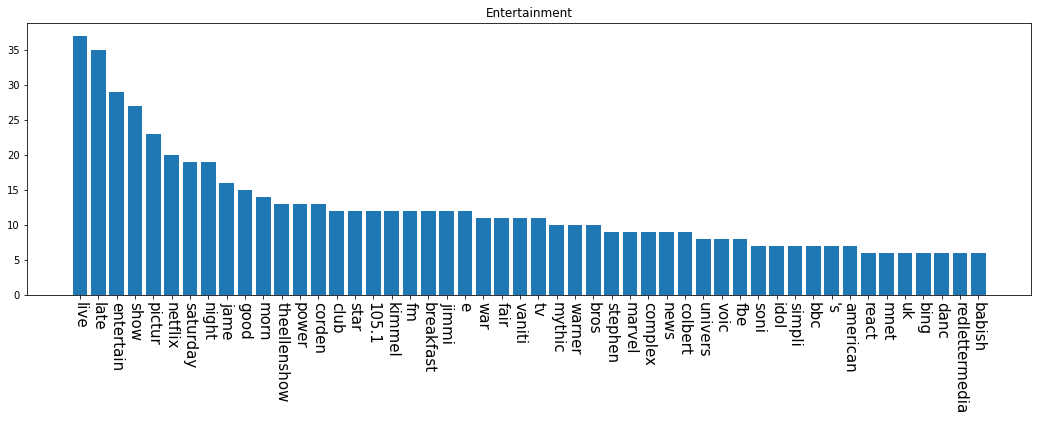

Category 'Music' Attr: 'channel_titles' unique words: 540


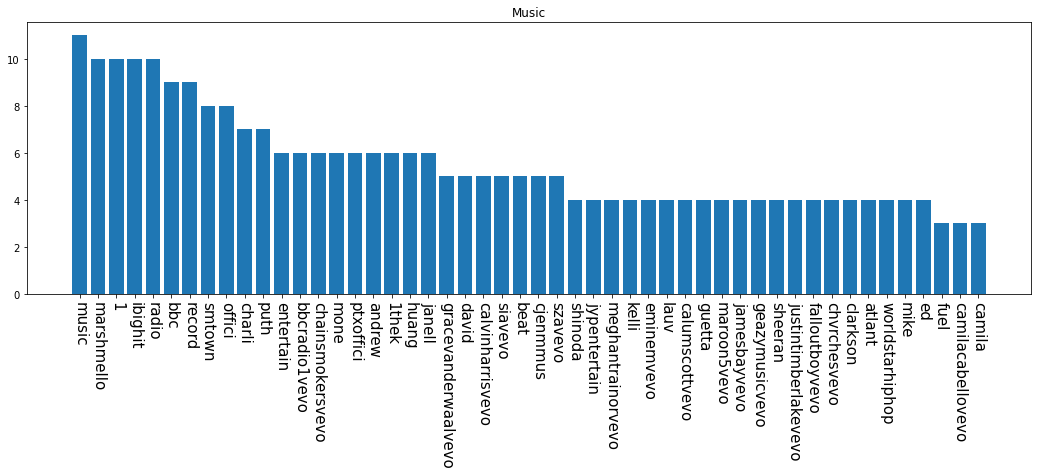

Category 'People & Blogs' Attr: 'channel_titles' unique words: 280


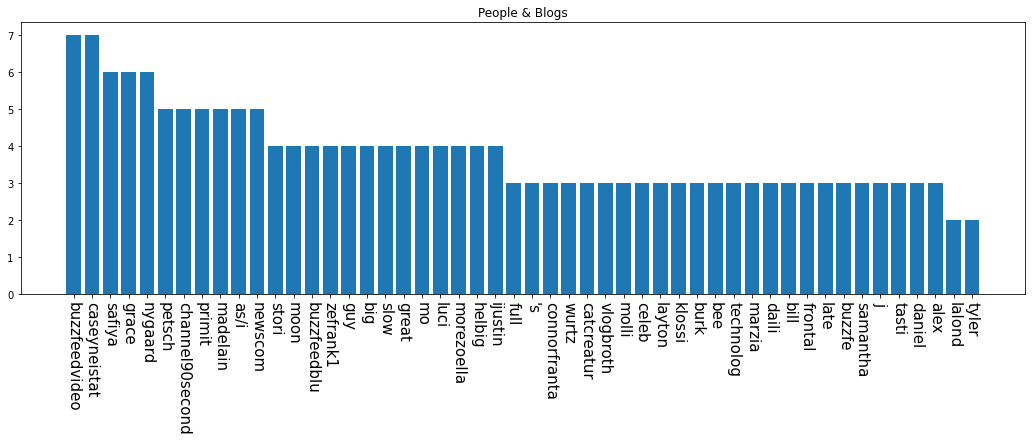

Category 'Howto & Style' Attr: 'channel_titles' unique words: 181


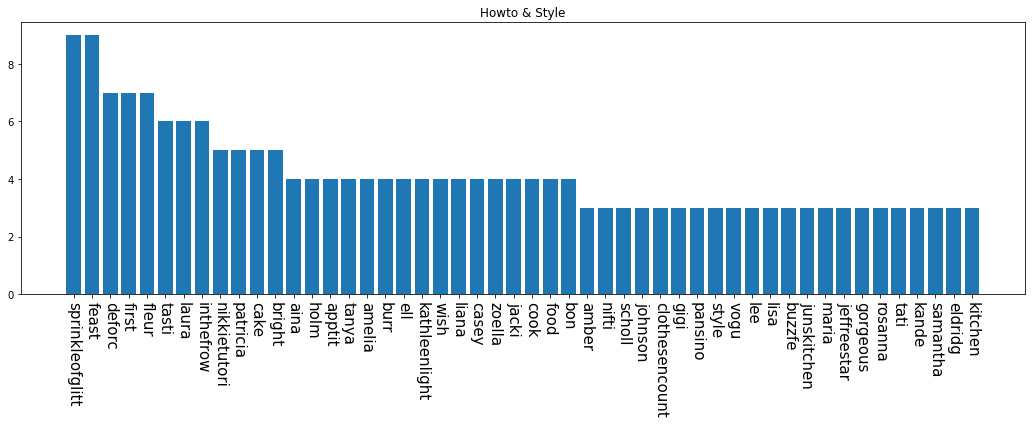

Category 'News & Politics' Attr: 'channel_titles' unique words: 105


Category 'Comedy' Attr: 'channel_titles' unique words: 162


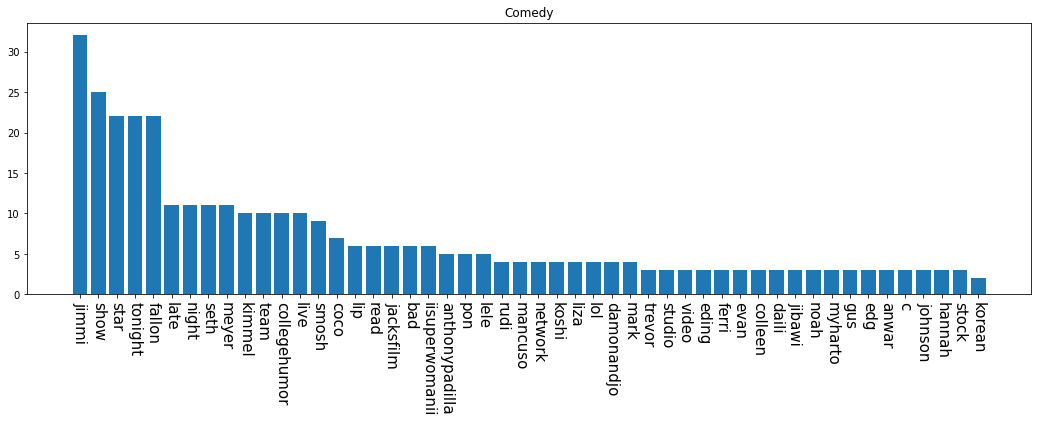

Category 'Sports' Attr: 'channel_titles' unique words: 139


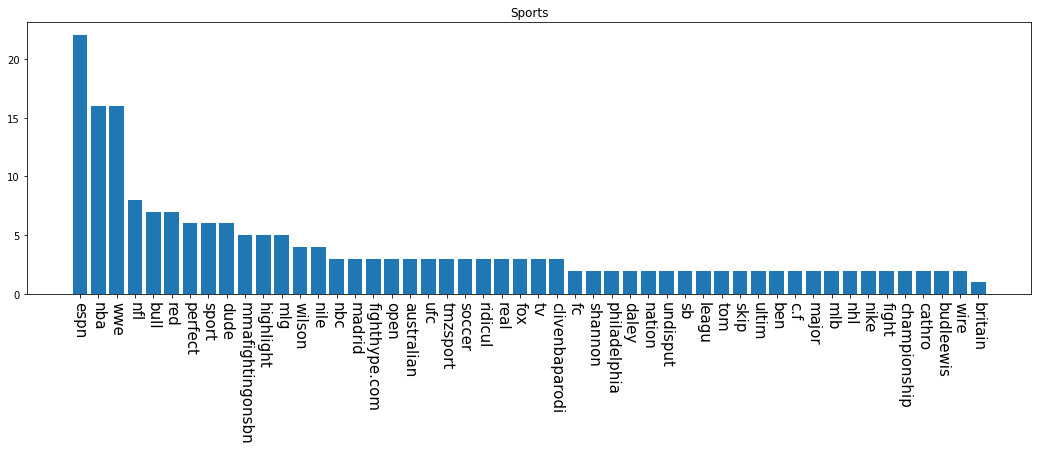

Category 'Travel & Events' Attr: 'channel_titles' unique words: 24


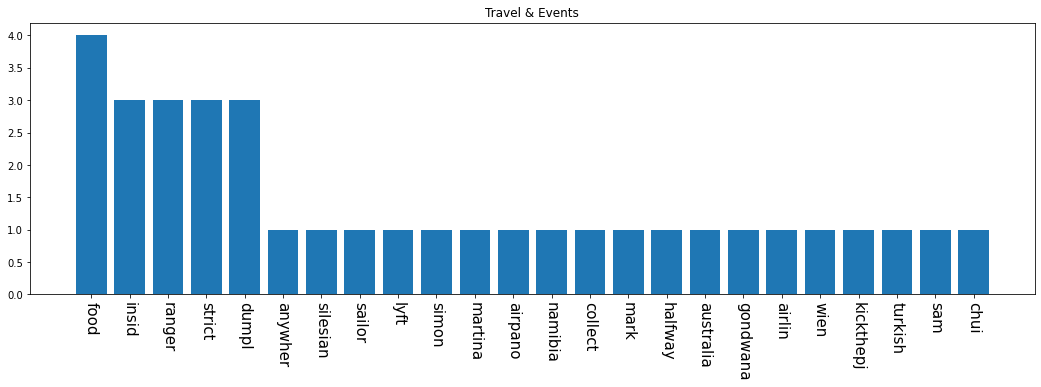

Category 'Gaming' Attr: 'channel_titles' unique words: 118


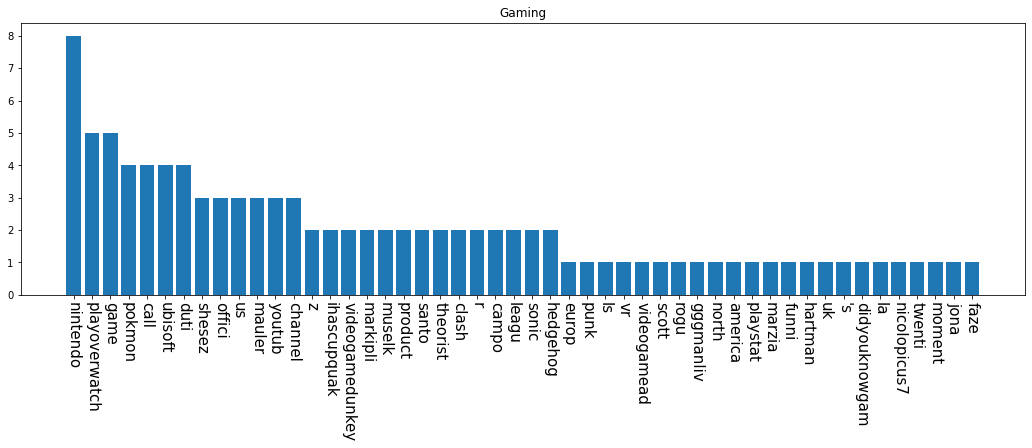

Category 'Education' Attr: 'channel_titles' unique words: 61


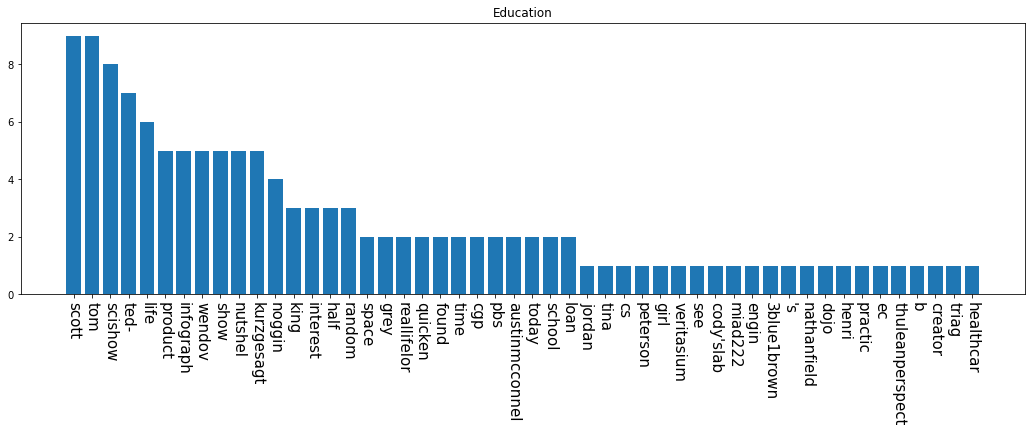

Category 'Pets & Animals' Attr: 'channel_titles' unique words: 61


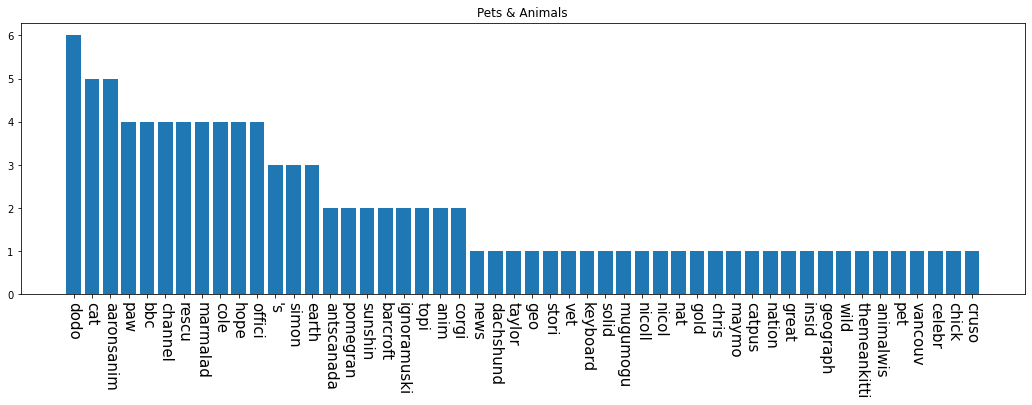

Category 'Science & Technology' Attr: 'channel_titles' unique words: 106


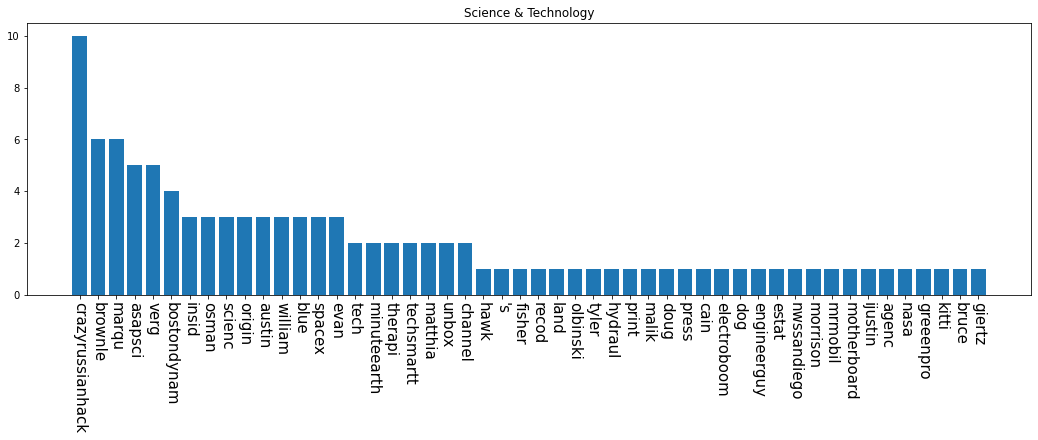

Category 'Film & Animation' Attr: 'channel_titles' unique words: 144


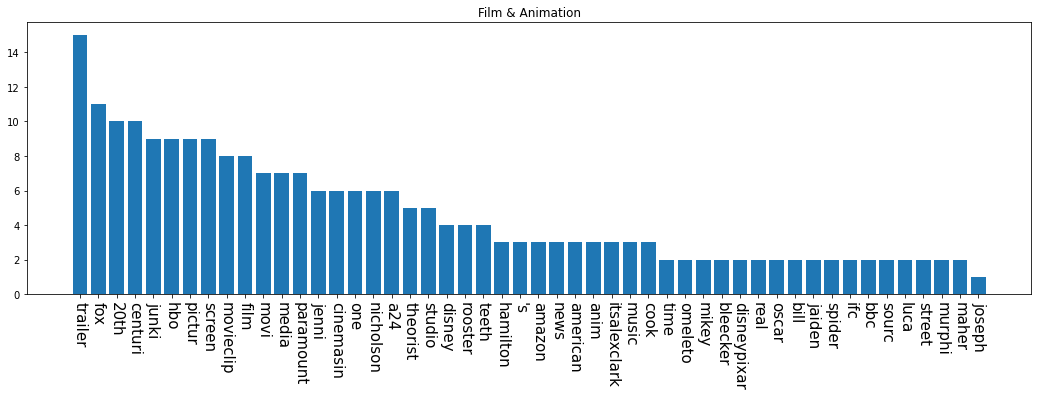

Category 'Autos & Vehicles' Attr: 'channel_titles' unique words: 25


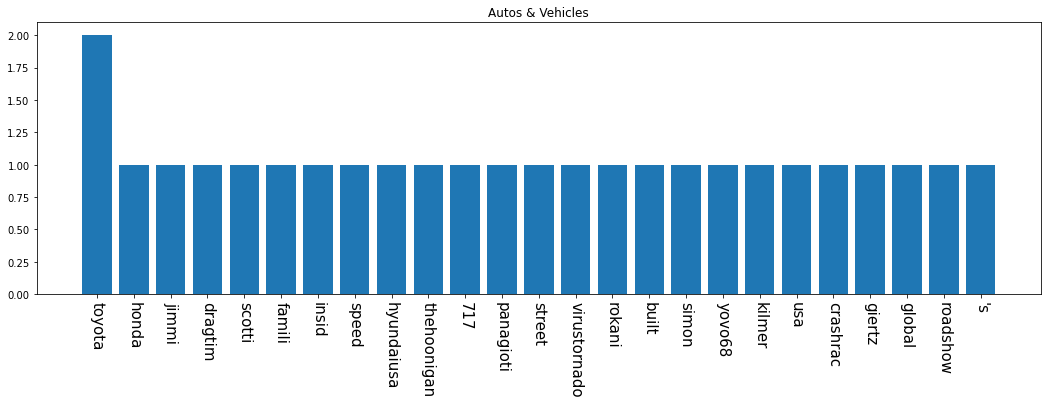

Category 'Nonprofits & Activism' Attr: 'channel_titles' unique words: 8


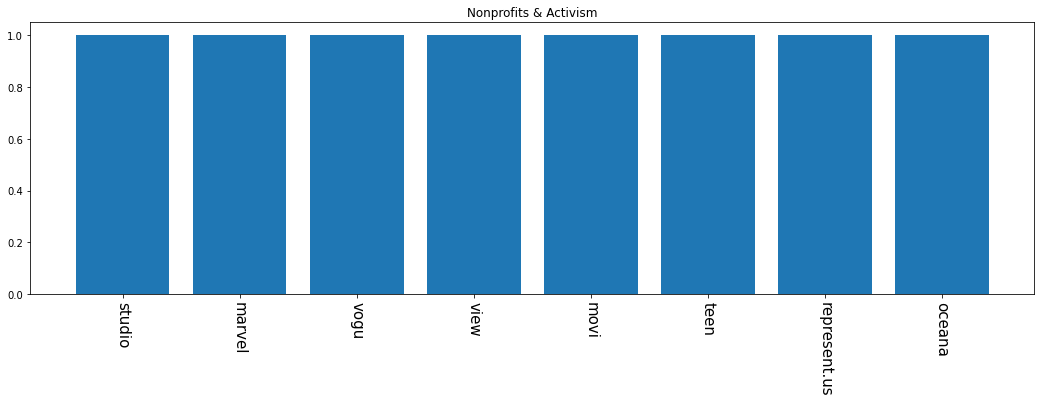

Category 'Shows' Attr: 'channel_titles' unique words: 3


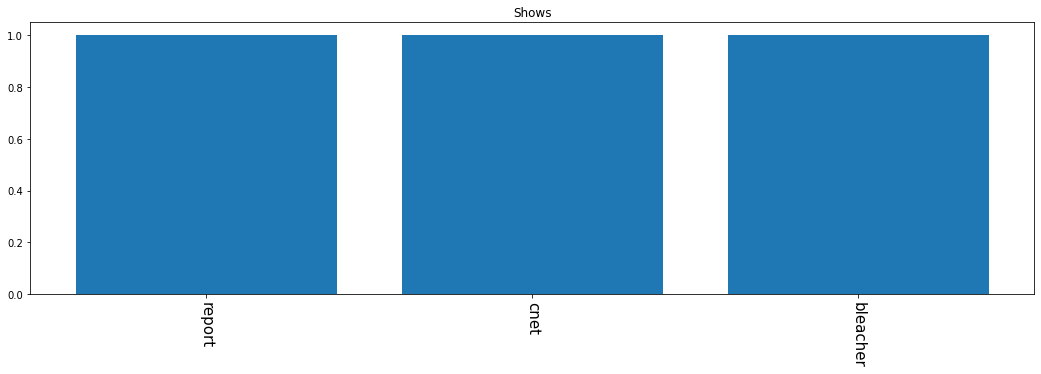

In [9]:
plot_categories_bars(categories, "channel_titles")

## Tytuł filmu

Category 'Entertainment' Attr: 'titles' unique words: 2108


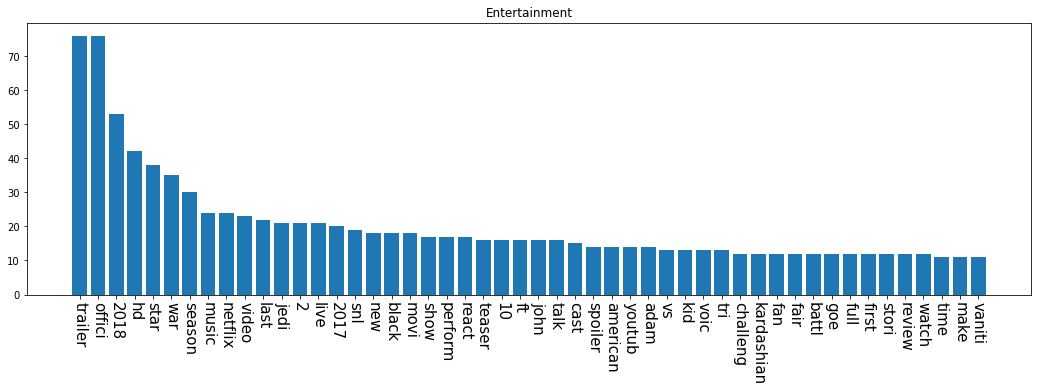

Category 'Music' Attr: 'titles' unique words: 1549


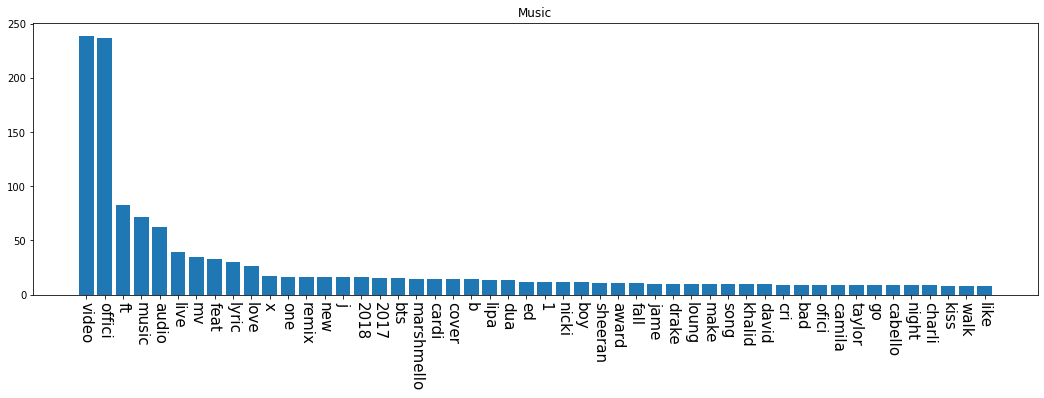

Category 'People & Blogs' Attr: 'titles' unique words: 899


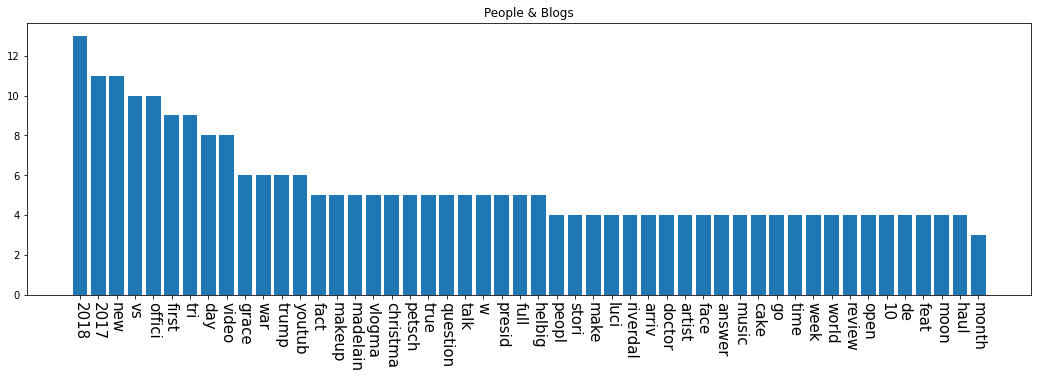

Category 'Howto & Style' Attr: 'titles' unique words: 791


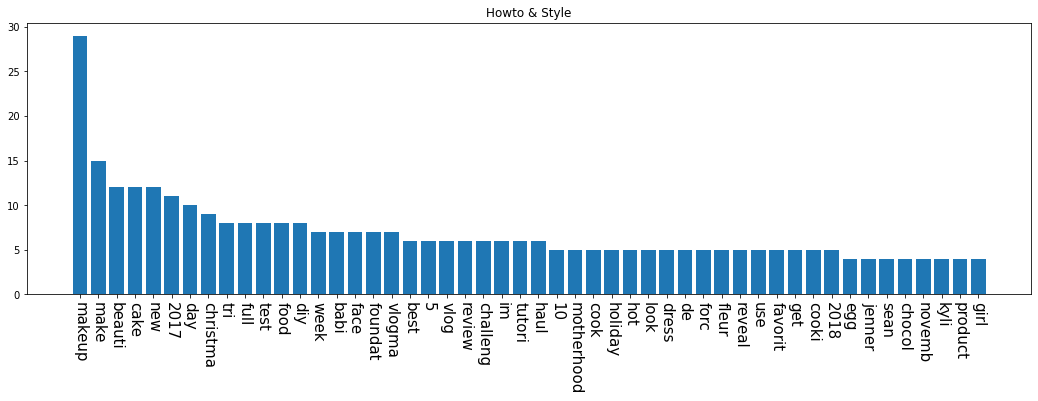

Category 'News & Politics' Attr: 'titles' unique words: 768


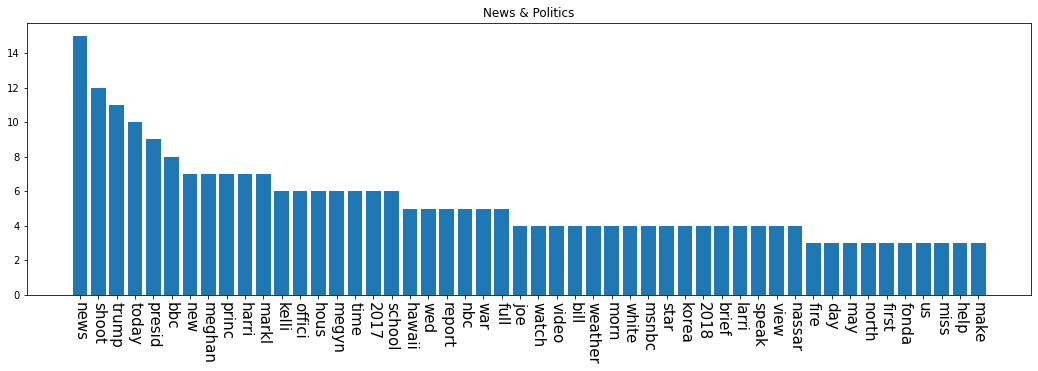

Category 'Comedy' Attr: 'titles' unique words: 759


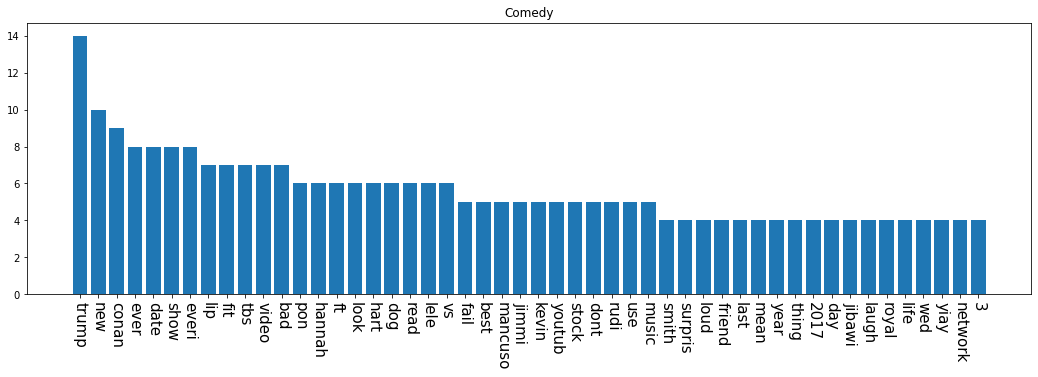

Category 'Sports' Attr: 'titles' unique words: 874


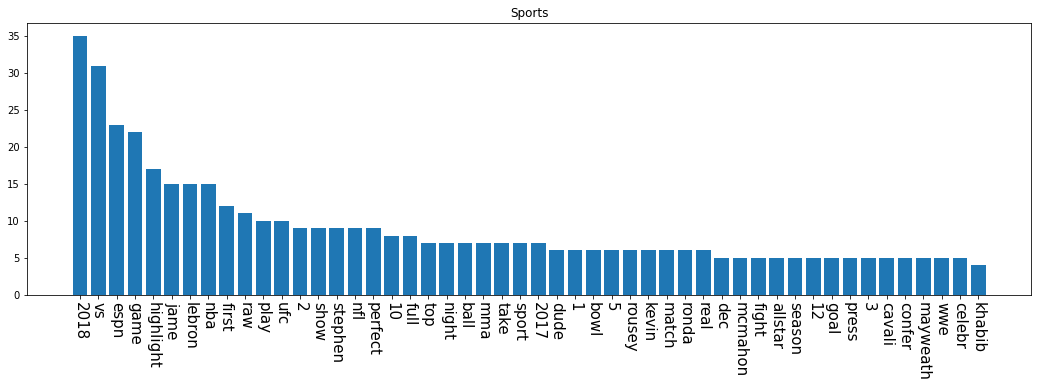

Category 'Travel & Events' Attr: 'titles' unique words: 111


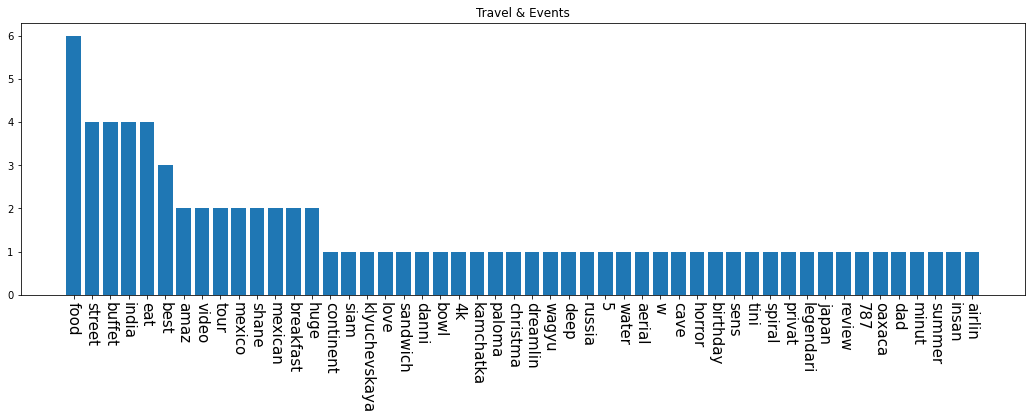

Category 'Gaming' Attr: 'titles' unique words: 440


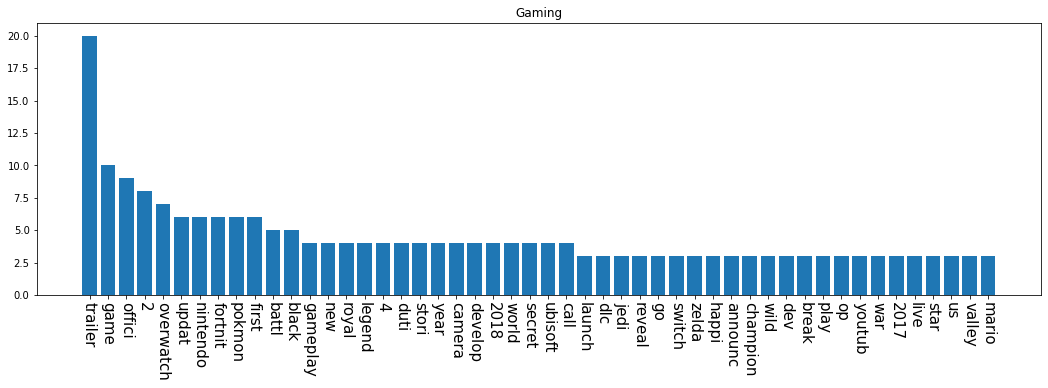

Category 'Education' Attr: 'titles' unique words: 301


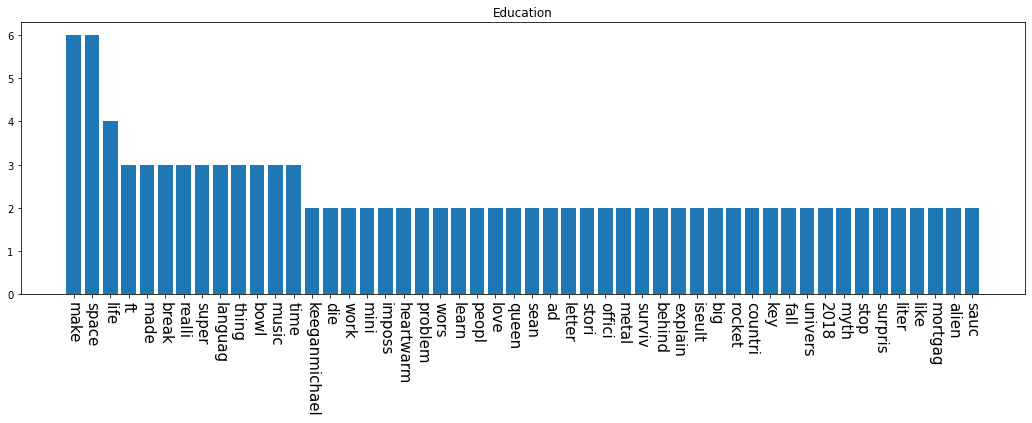

Category 'Pets & Animals' Attr: 'titles' unique words: 212


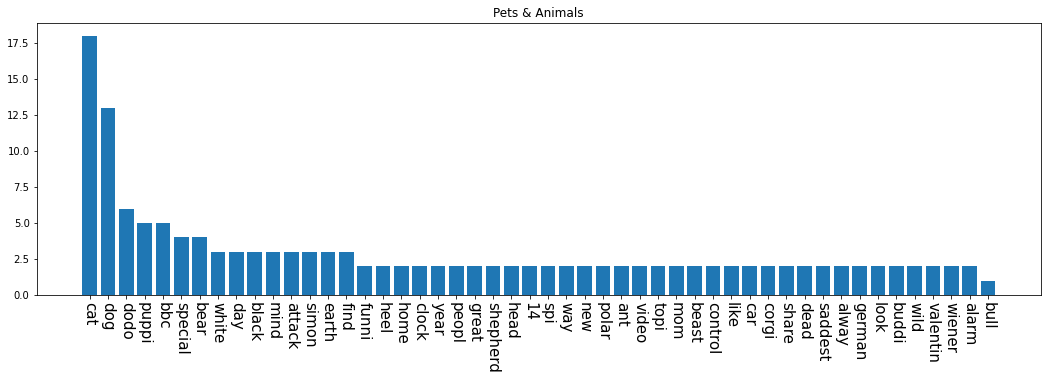

Category 'Science & Technology' Attr: 'titles' unique words: 401


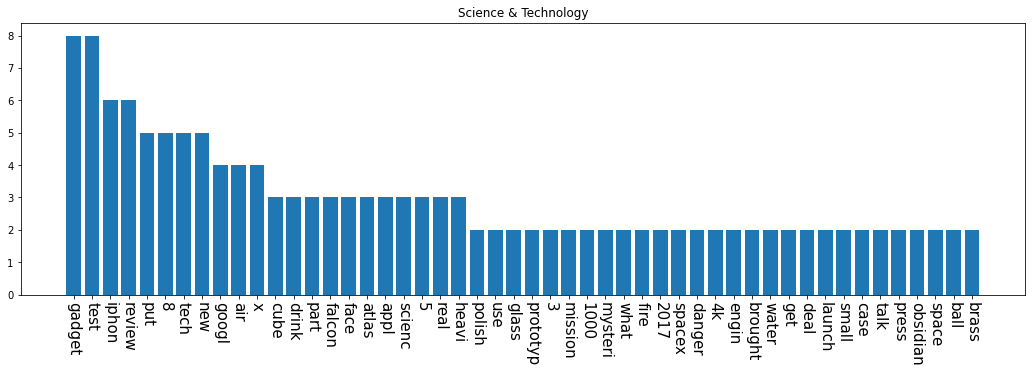

Category 'Film & Animation' Attr: 'titles' unique words: 568


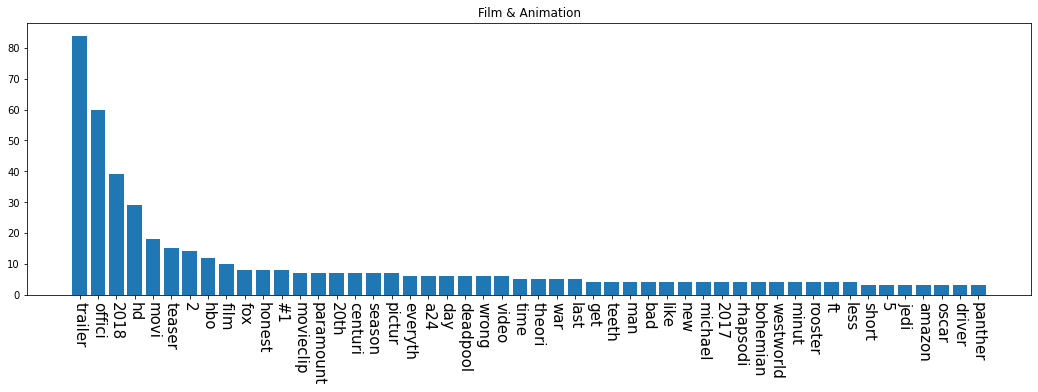

Category 'Autos & Vehicles' Attr: 'titles' unique words: 104


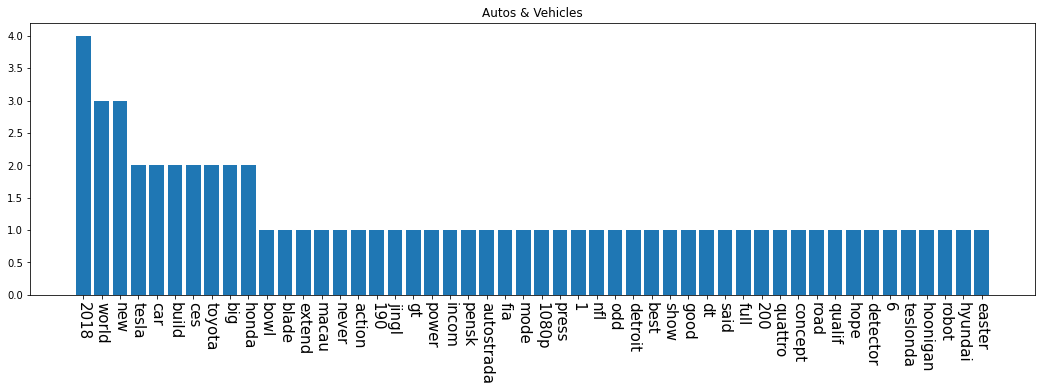

Category 'Nonprofits & Activism' Attr: 'titles' unique words: 34


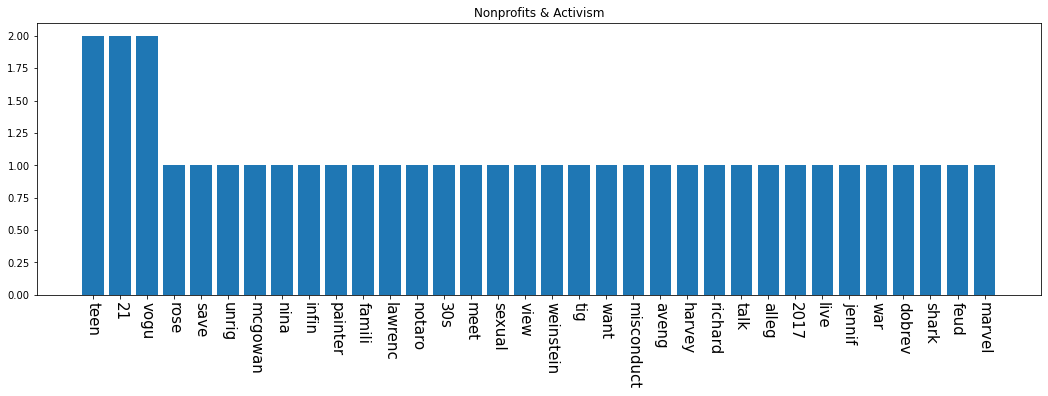

Category 'Shows' Attr: 'titles' unique words: 12


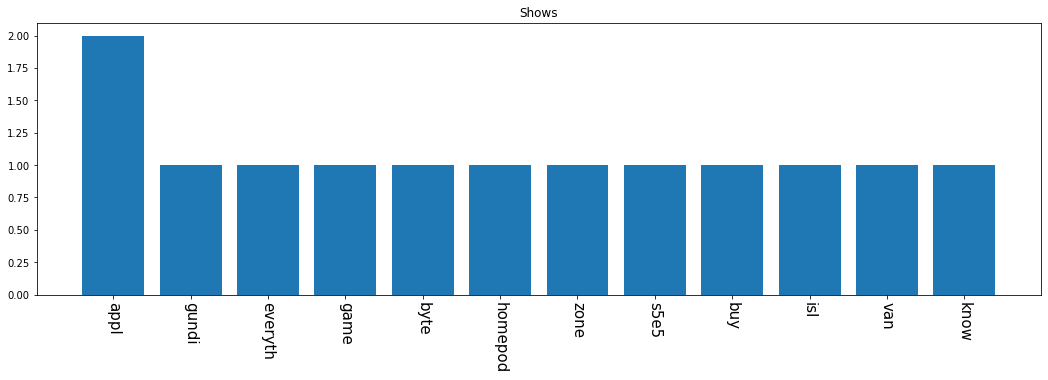

In [10]:
plot_categories_bars(categories, "titles")

## Opisy filmów

Category 'Entertainment' Attr: 'descriptions' unique words: 11357


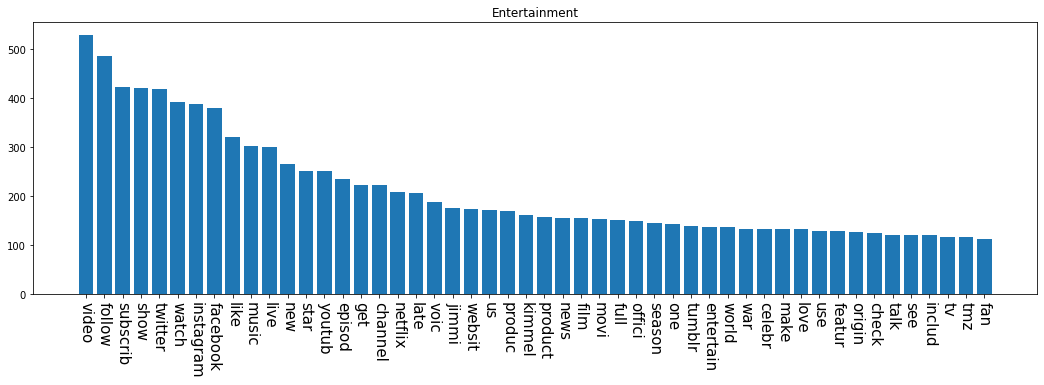

Category 'Music' Attr: 'descriptions' unique words: 11529


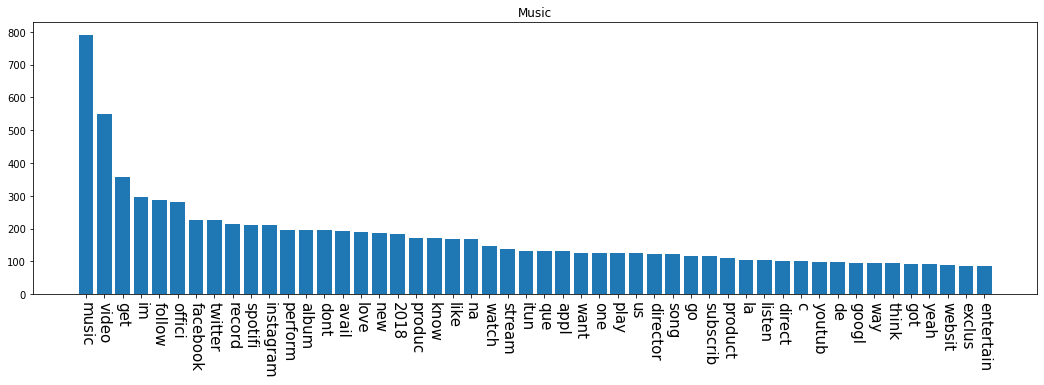

Category 'People & Blogs' Attr: 'descriptions' unique words: 6058


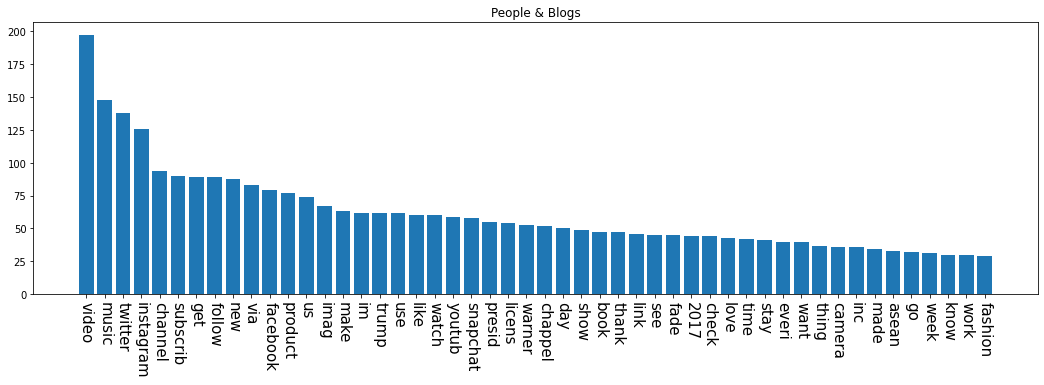

Category 'Howto & Style' Attr: 'descriptions' unique words: 7011


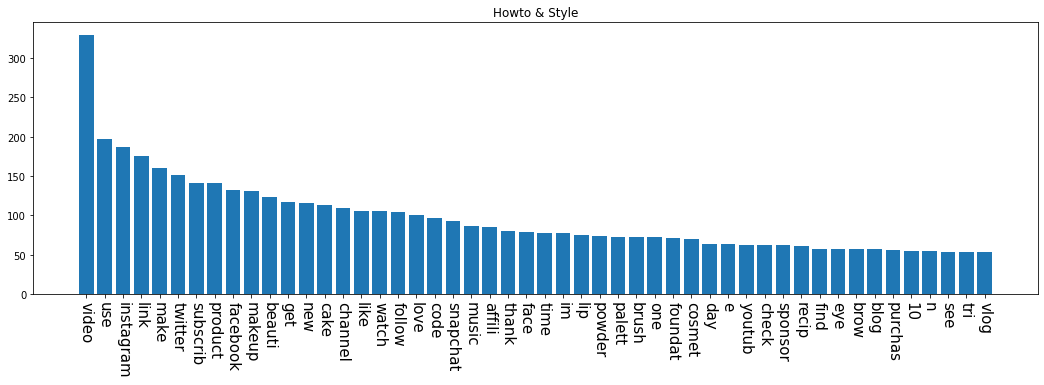

Category 'News & Politics' Attr: 'descriptions' unique words: 2900


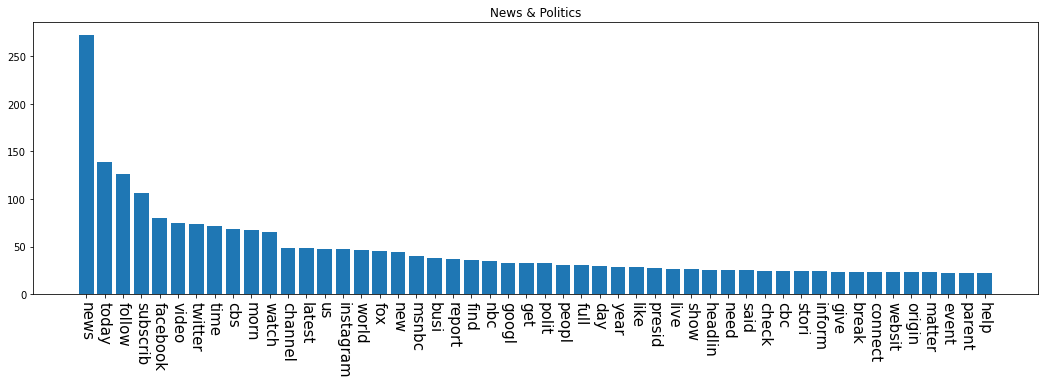

Category 'Comedy' Attr: 'descriptions' unique words: 4420


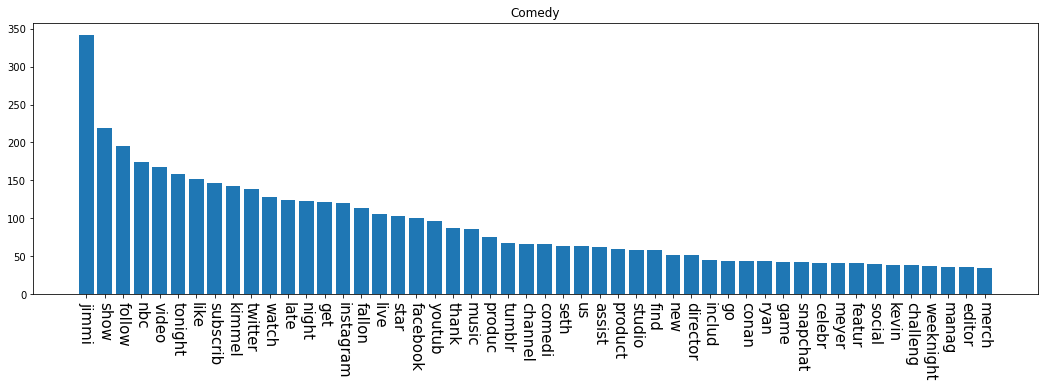

Category 'Sports' Attr: 'descriptions' unique words: 3494


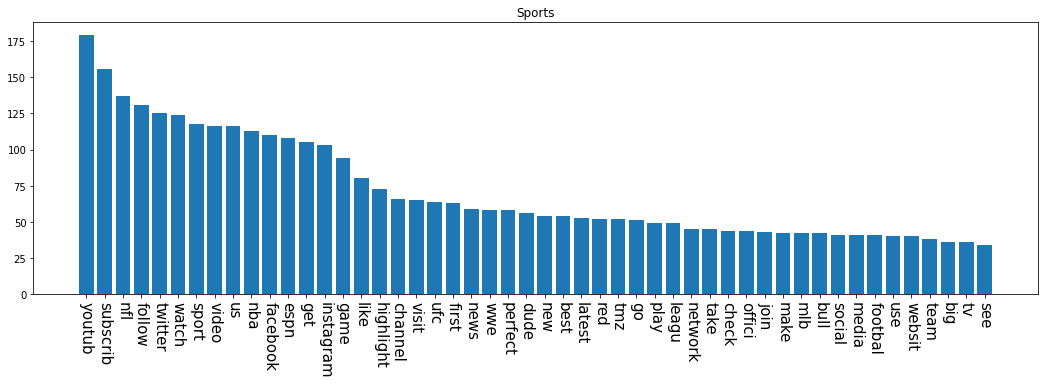

Category 'Travel & Events' Attr: 'descriptions' unique words: 910


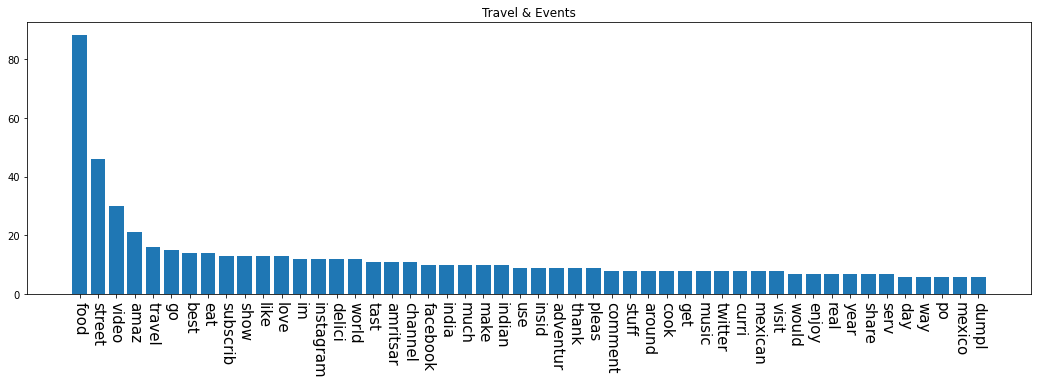

Category 'Gaming' Attr: 'descriptions' unique words: 2719


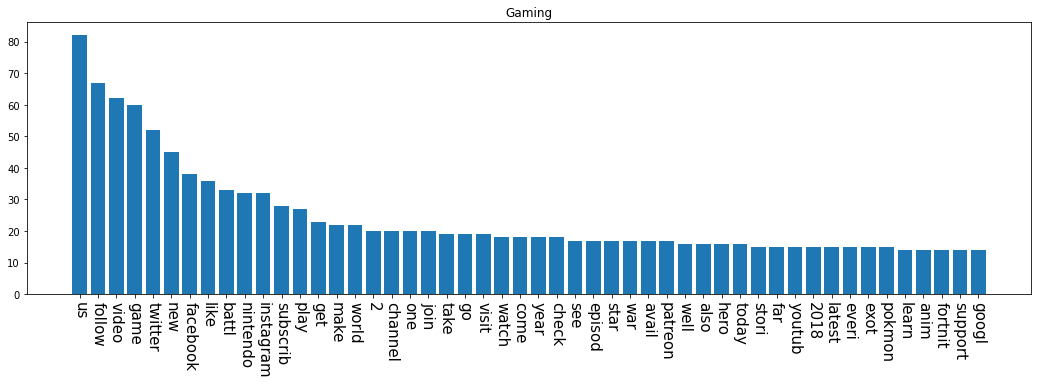

Category 'Education' Attr: 'descriptions' unique words: 3723


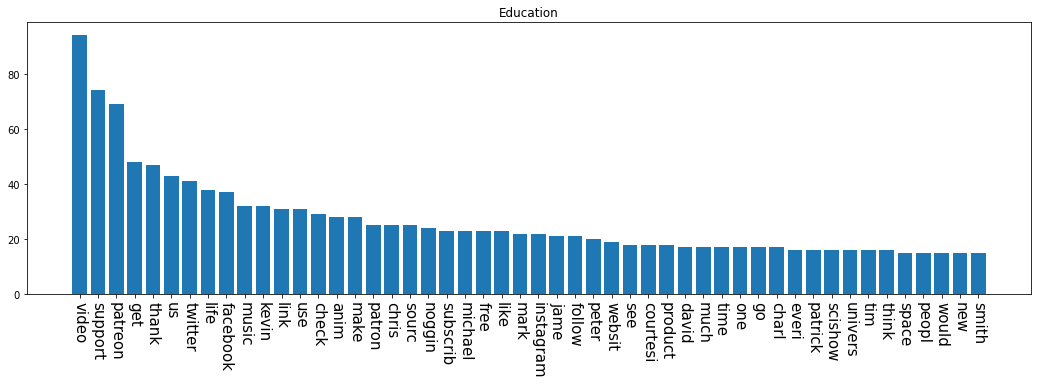

Category 'Pets & Animals' Attr: 'descriptions' unique words: 1345


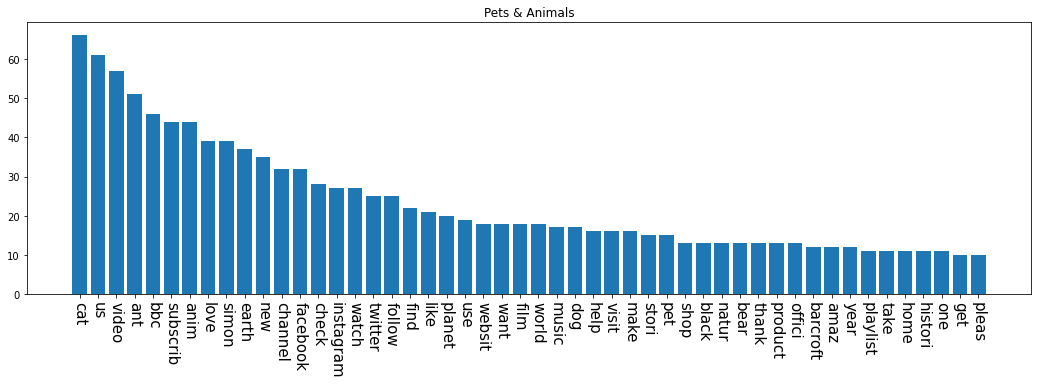

Category 'Science & Technology' Attr: 'descriptions' unique words: 3351


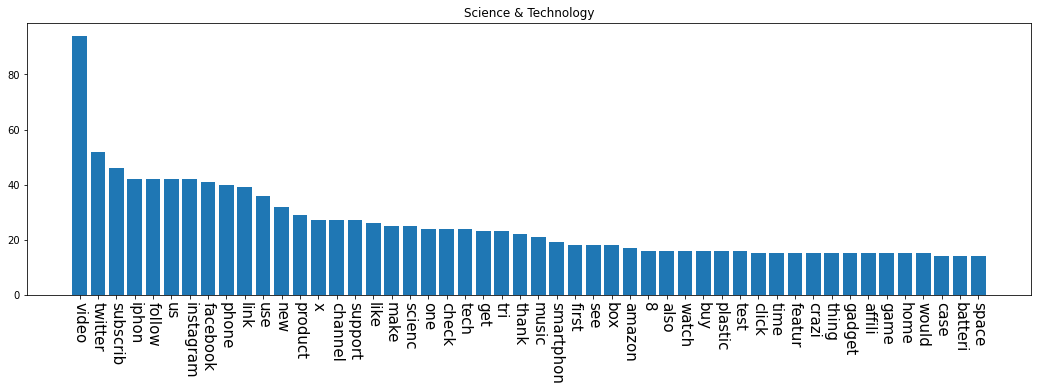

Category 'Film & Animation' Attr: 'descriptions' unique words: 4791


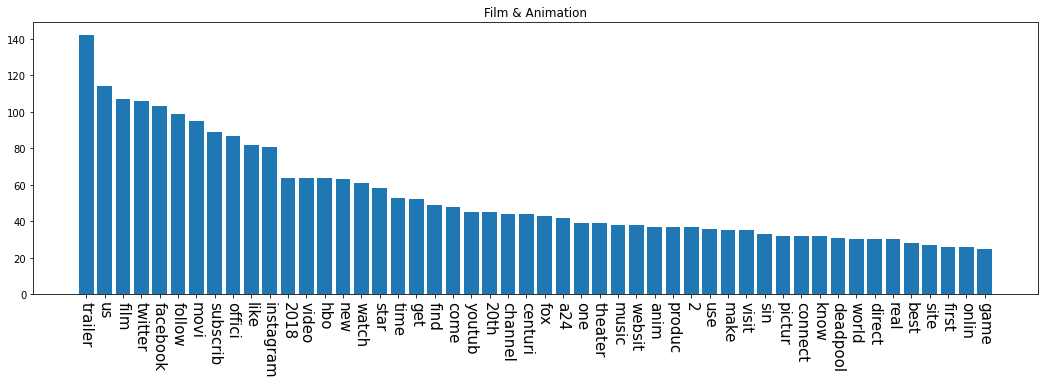

Category 'Autos & Vehicles' Attr: 'descriptions' unique words: 670


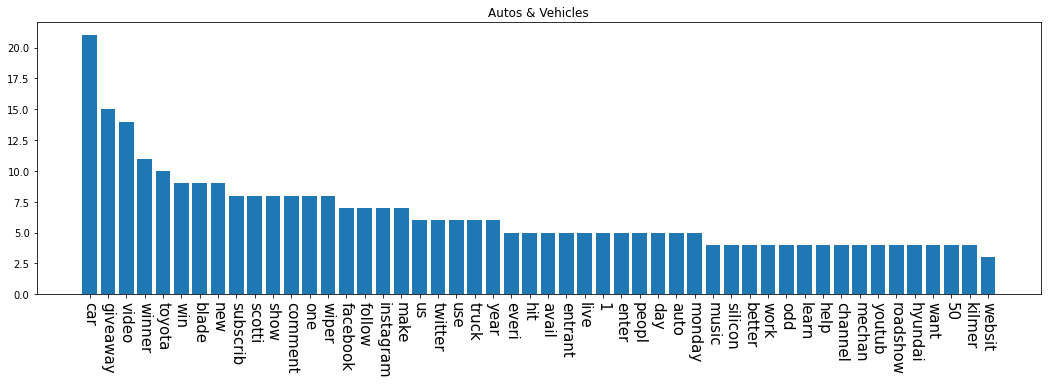

Category 'Nonprofits & Activism' Attr: 'descriptions' unique words: 103


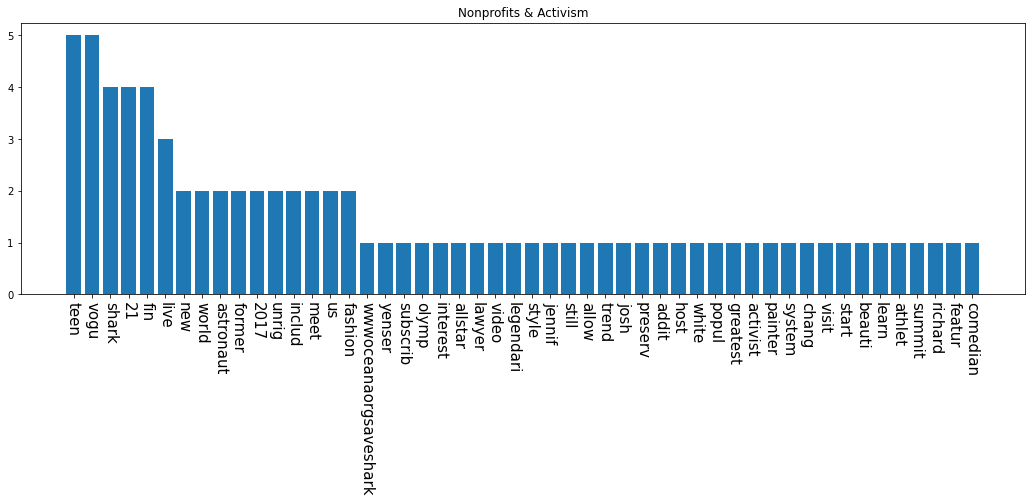

Category 'Shows' Attr: 'descriptions' unique words: 56


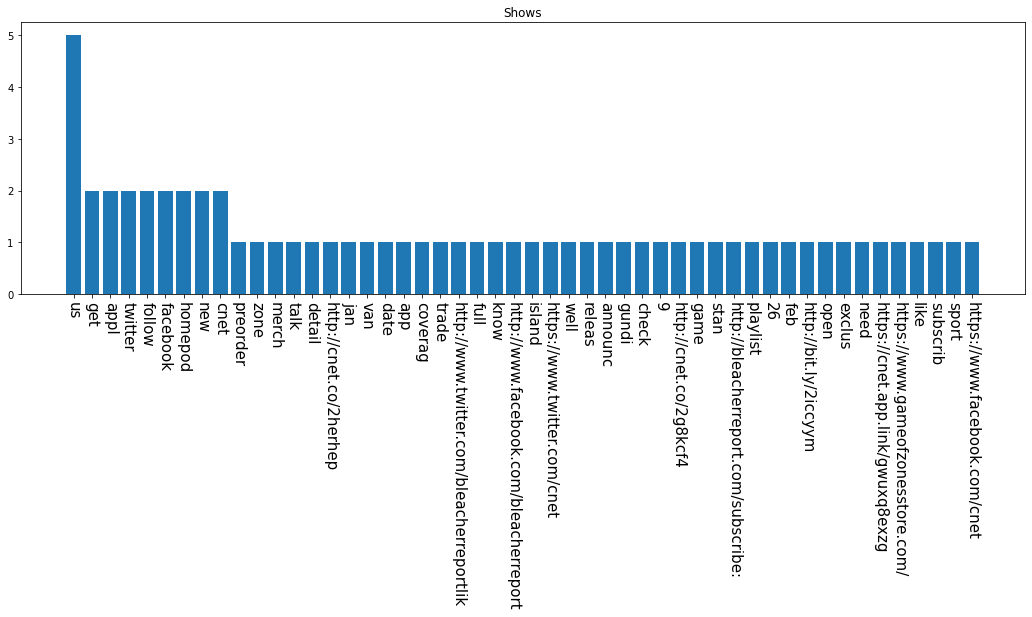

In [11]:
plot_categories_bars(categories, "descriptions")

## OCR

Category 'Entertainment' Attr: 'ocr_text' unique words: 135


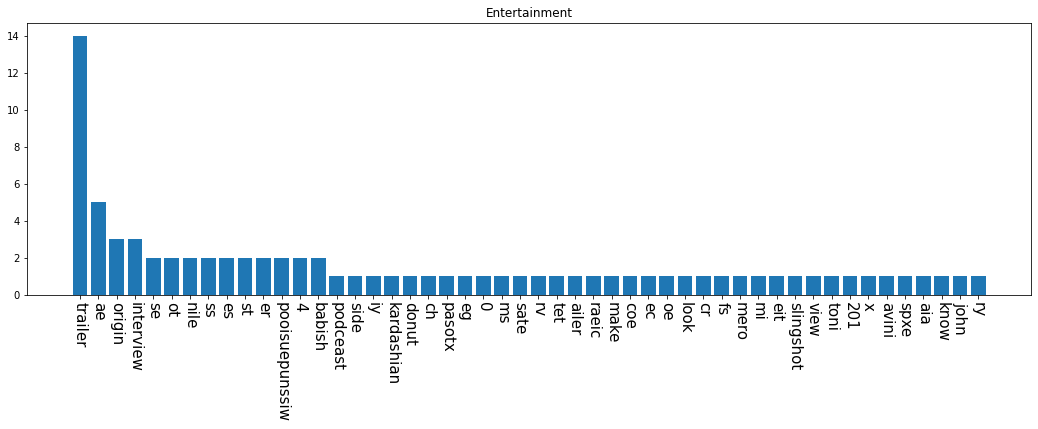

Category 'Music' Attr: 'ocr_text' unique words: 99


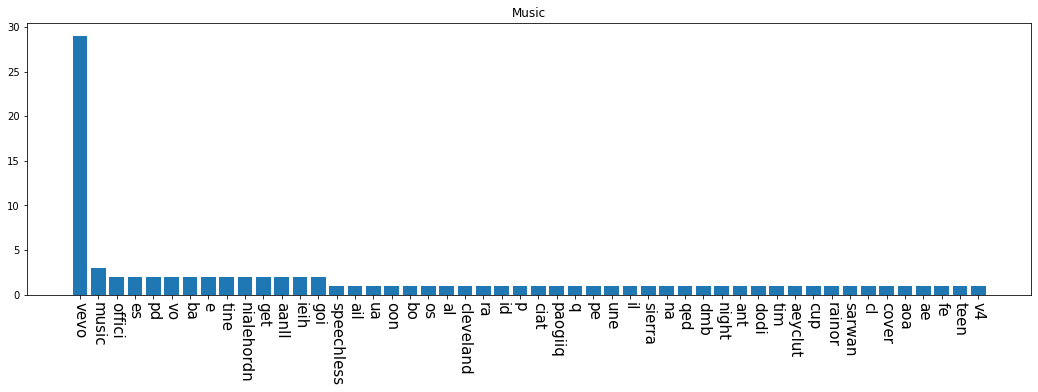

Category 'People & Blogs' Attr: 'ocr_text' unique words: 31


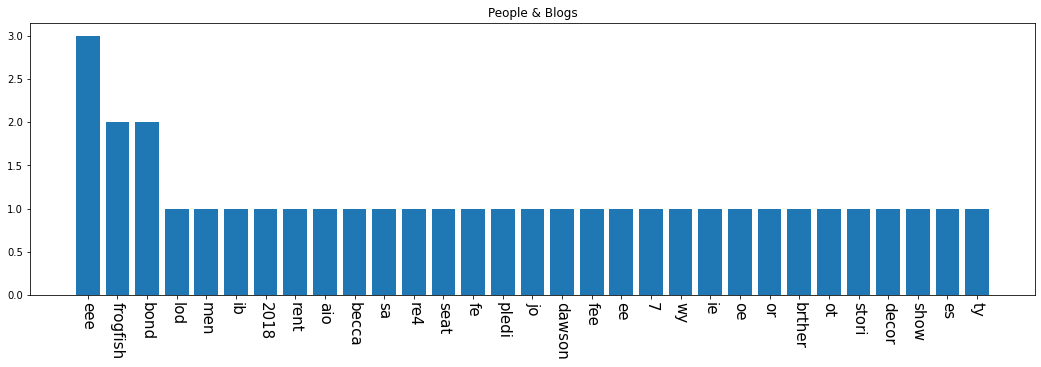

Category 'Howto & Style' Attr: 'ocr_text' unique words: 39


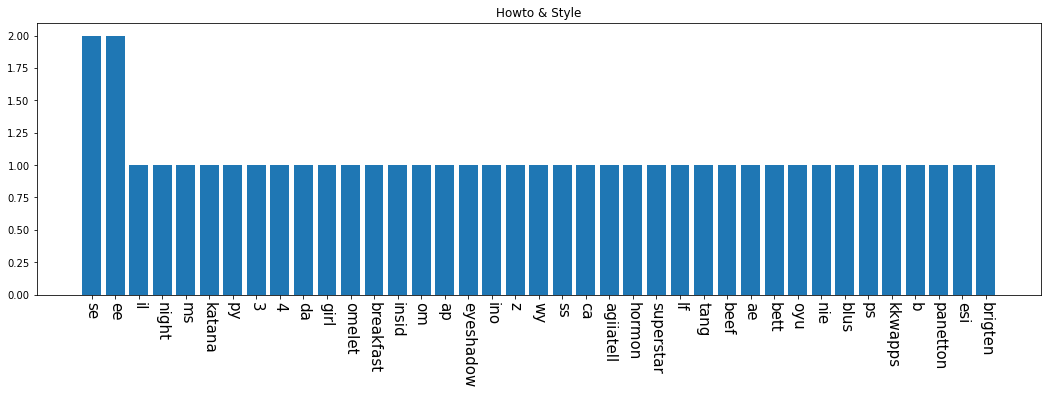

Category 'News & Politics' Attr: 'ocr_text' unique words: 29


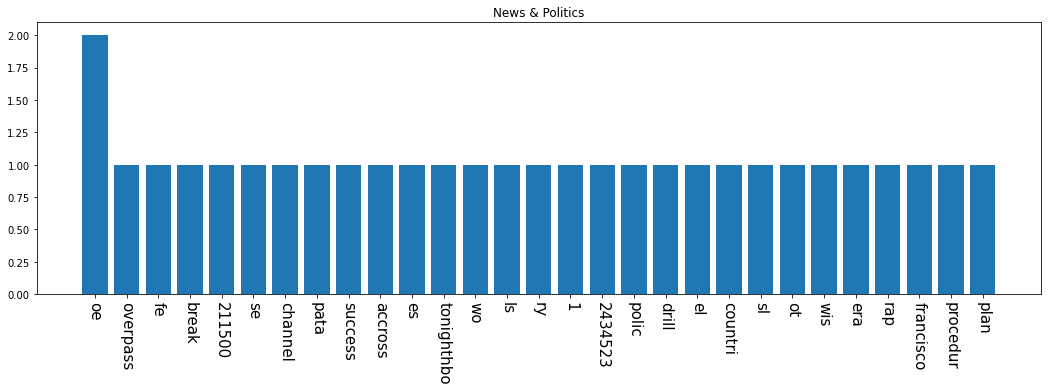

Category 'Comedy' Attr: 'ocr_text' unique words: 41


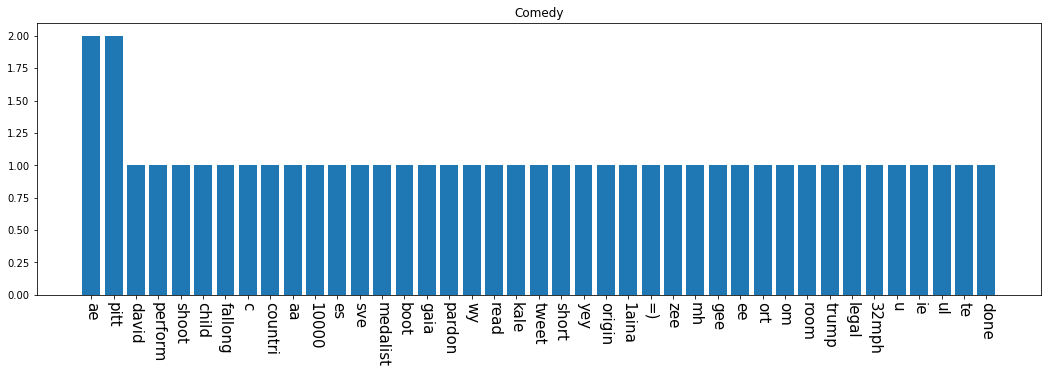

Category 'Sports' Attr: 'ocr_text' unique words: 38


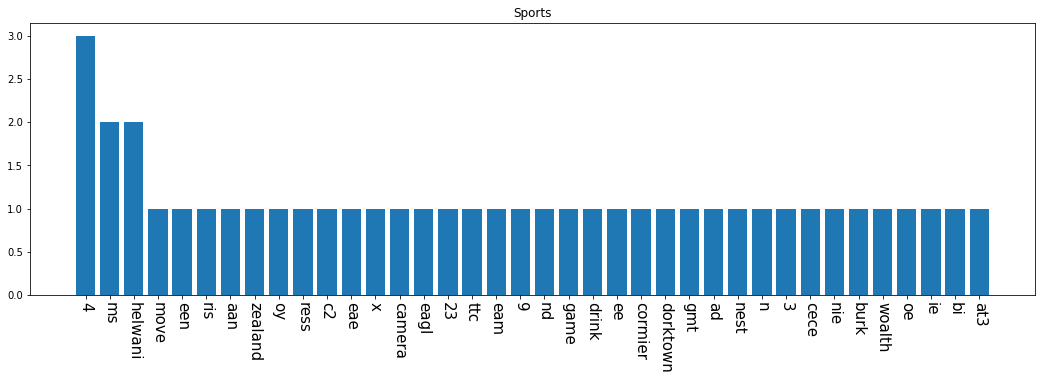

Category 'Travel & Events' Attr: 'ocr_text' unique words: 3


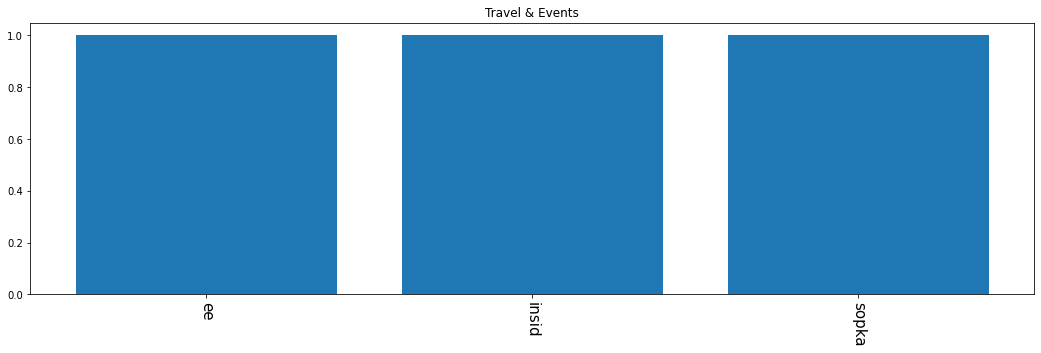

Category 'Gaming' Attr: 'ocr_text' unique words: 35


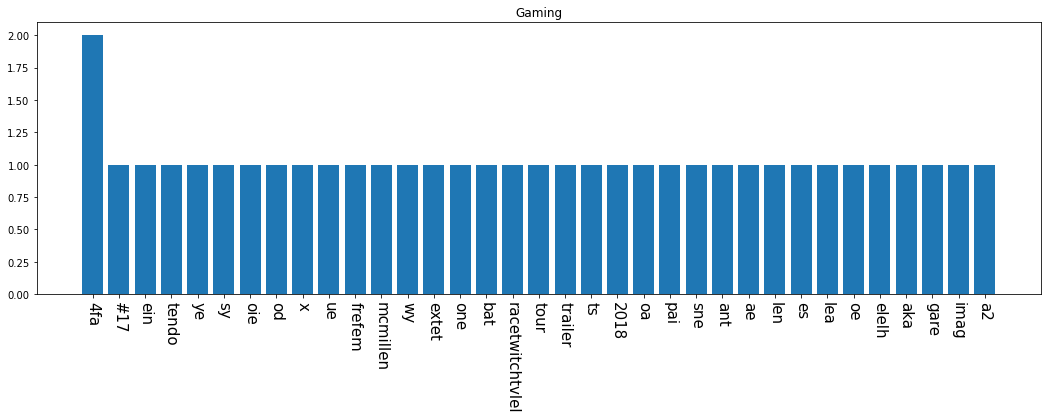

Category 'Education' Attr: 'ocr_text' unique words: 35


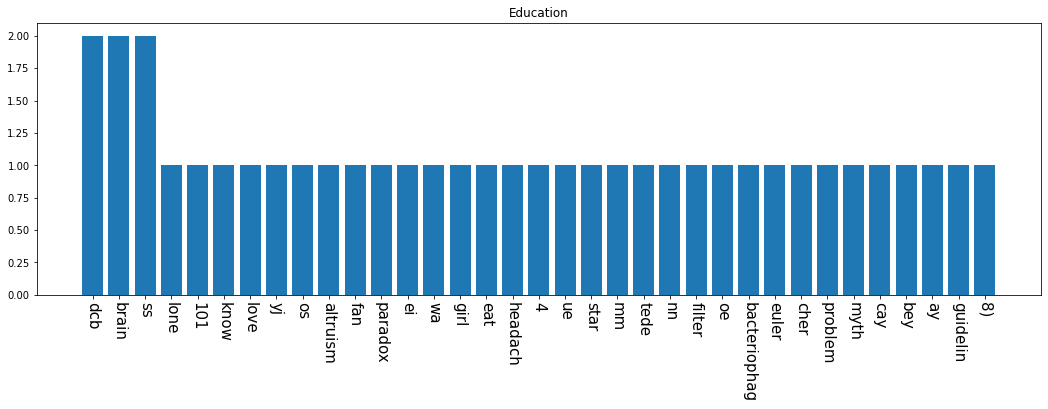

Category 'Pets & Animals' Attr: 'ocr_text' unique words: 5


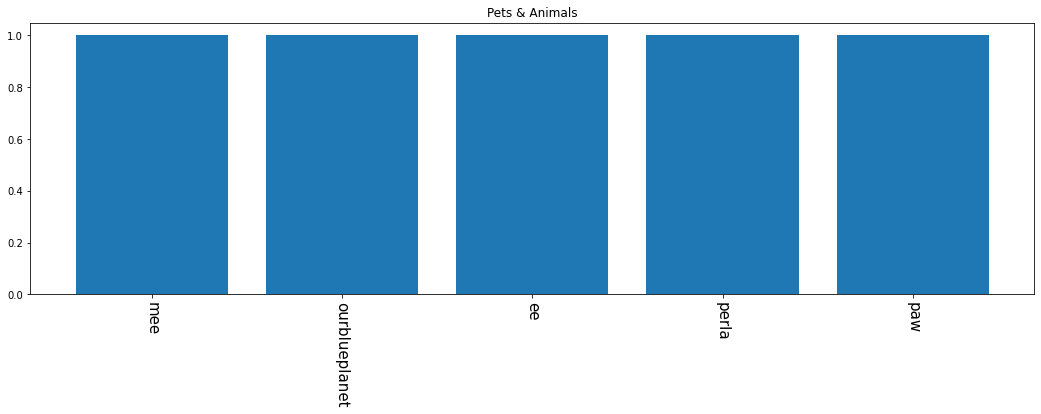

Category 'Science & Technology' Attr: 'ocr_text' unique words: 28


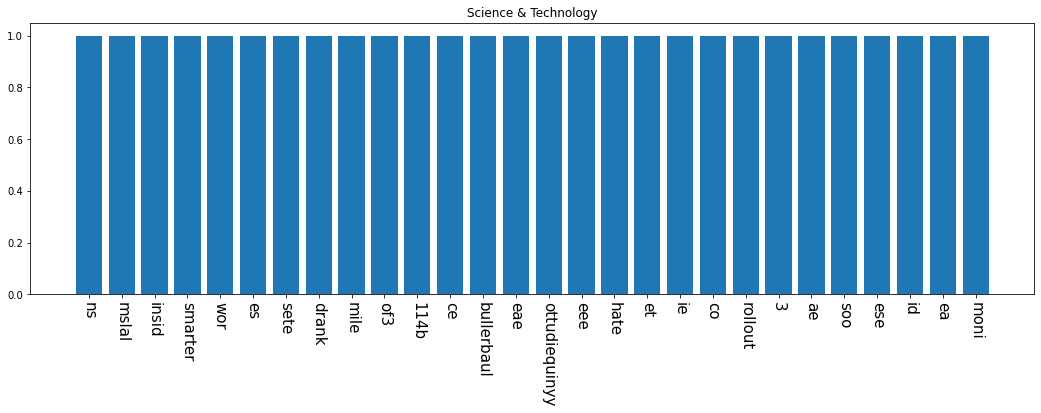

Category 'Film & Animation' Attr: 'ocr_text' unique words: 42


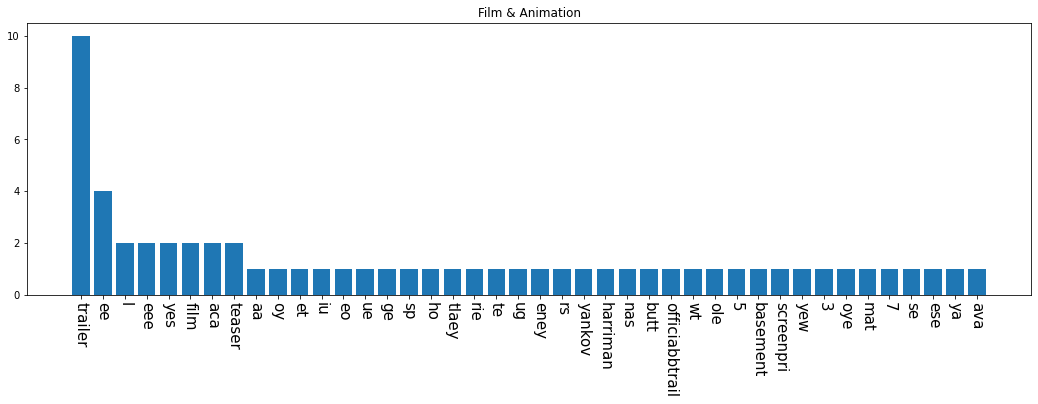

Category 'Autos & Vehicles' Attr: 'ocr_text' unique words: 2


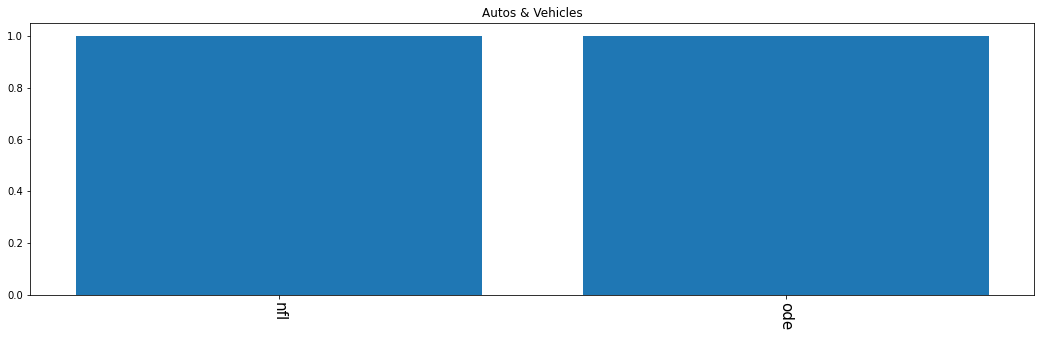

Category 'Nonprofits & Activism' Attr: 'ocr_text' unique words: 1


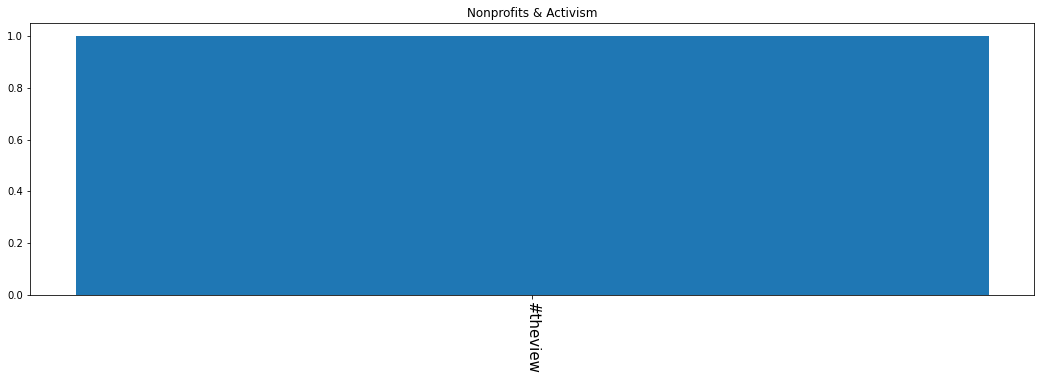

Category 'Shows' Attr: 'ocr_text' unique words: 0


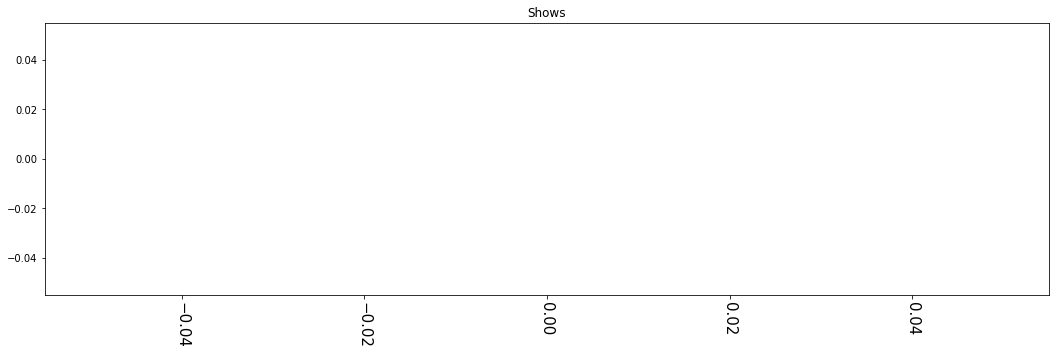

In [12]:
plot_categories_bars(categories, "ocr_text")

## Domeny

Category 'Entertainment' Attr: 'domains' unique words: 429


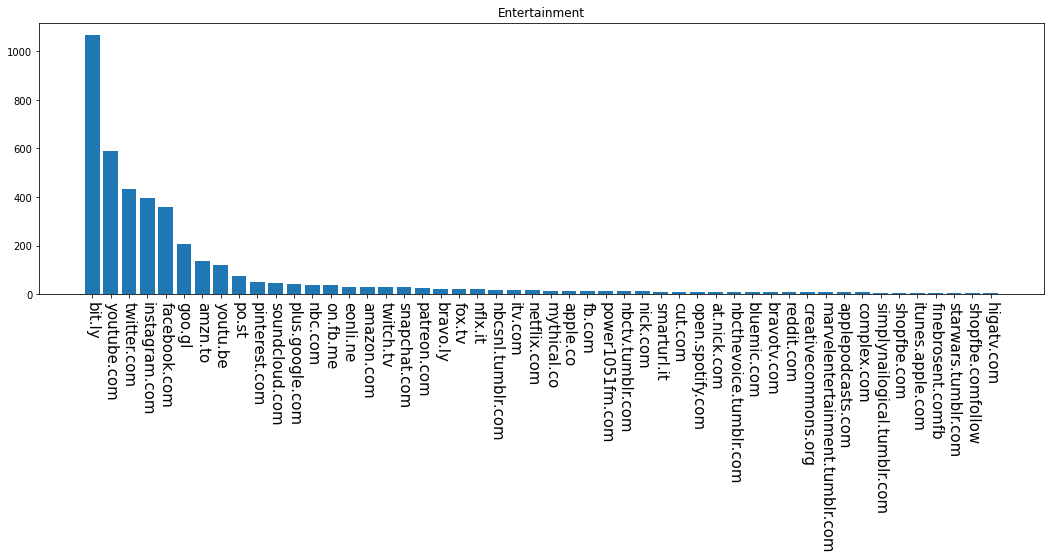

Category 'Music' Attr: 'domains' unique words: 473


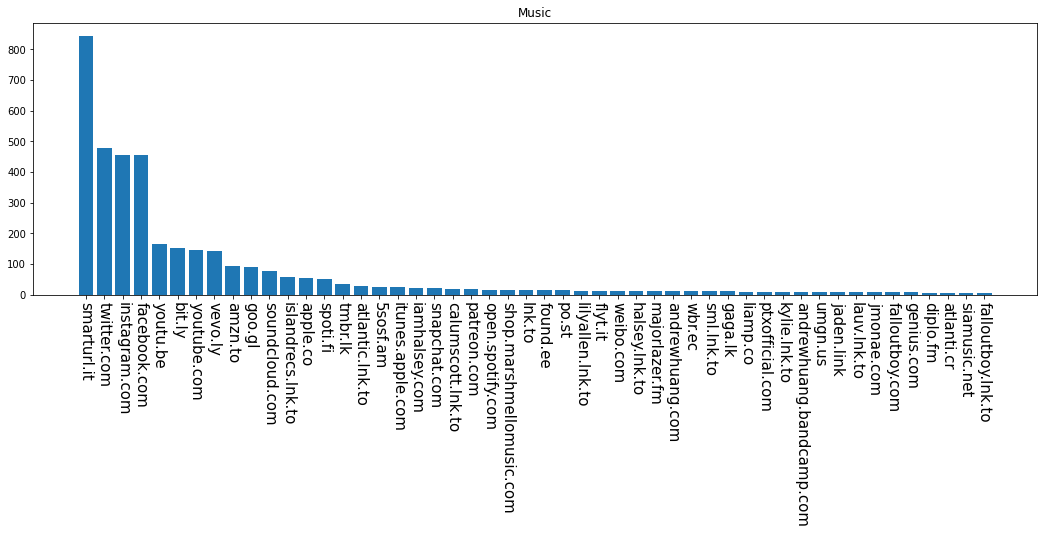

Category 'People & Blogs' Attr: 'domains' unique words: 214


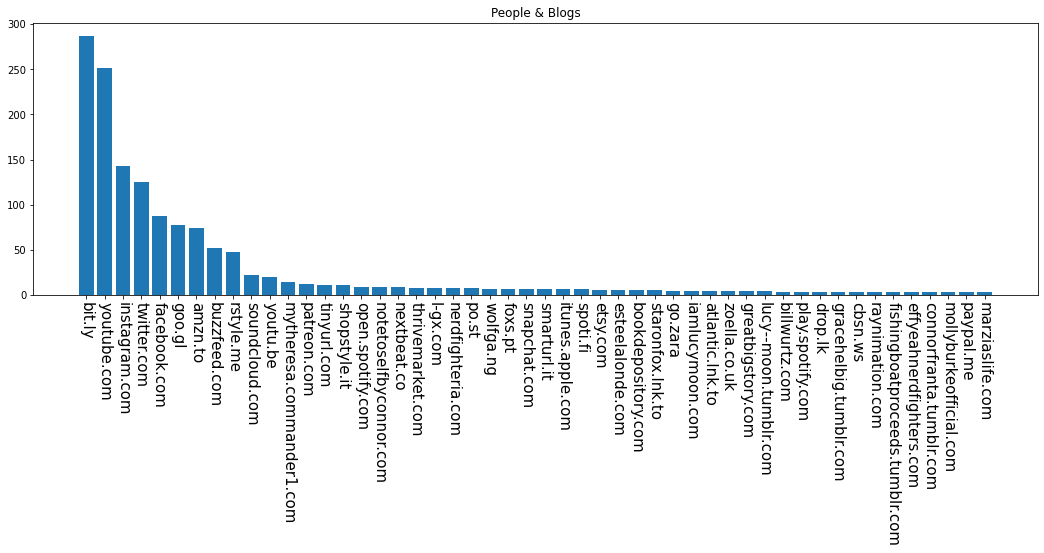

Category 'Howto & Style' Attr: 'domains' unique words: 222


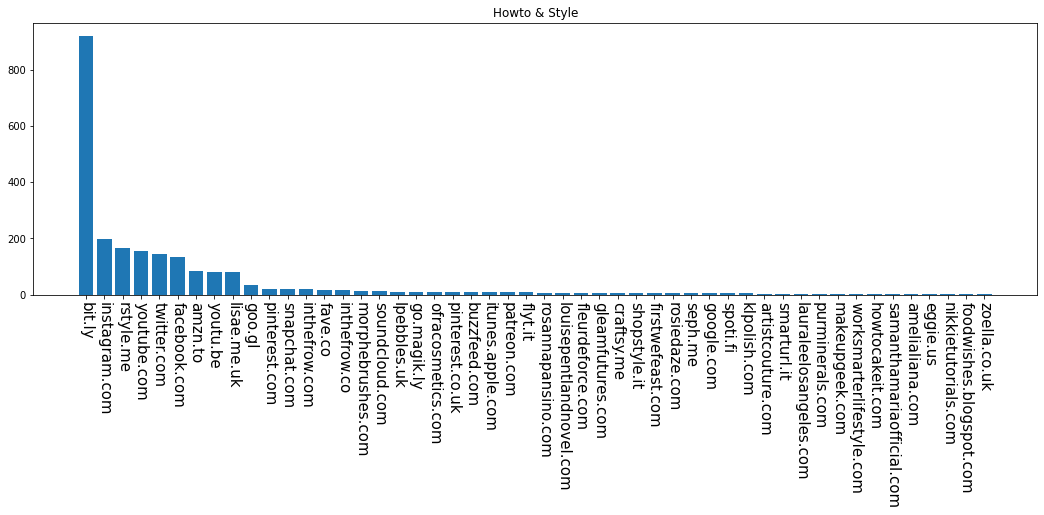

Category 'News & Politics' Attr: 'domains' unique words: 79


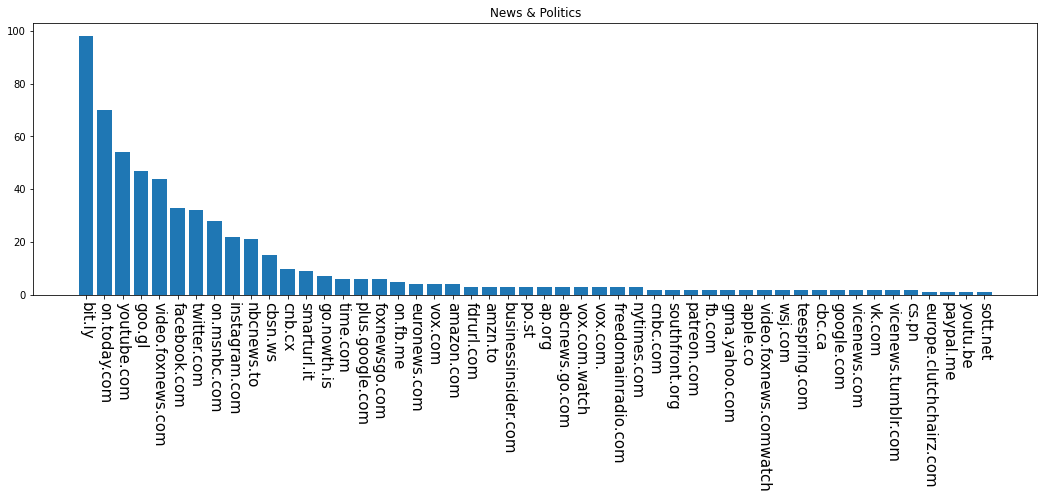

Category 'Comedy' Attr: 'domains' unique words: 135


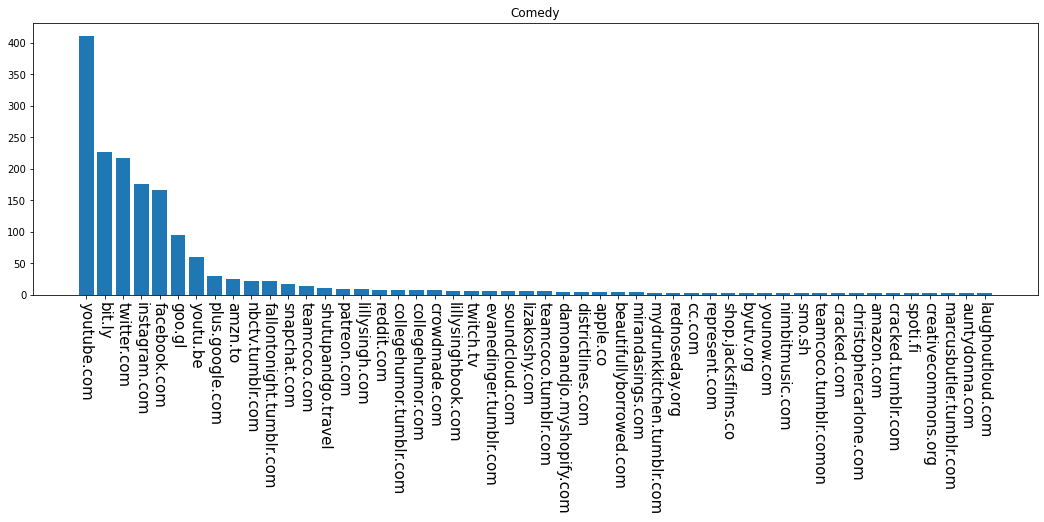

Category 'Sports' Attr: 'domains' unique words: 101


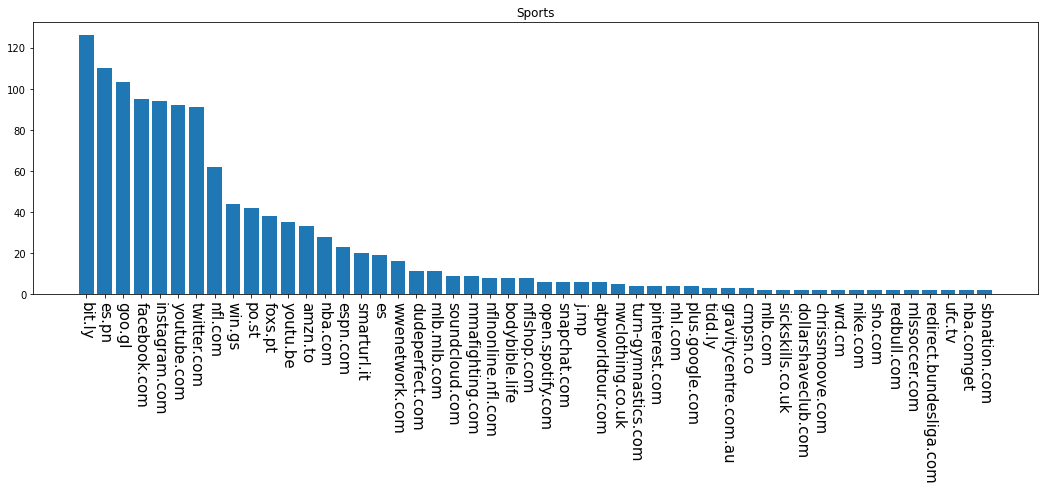

Category 'Travel & Events' Attr: 'domains' unique words: 36


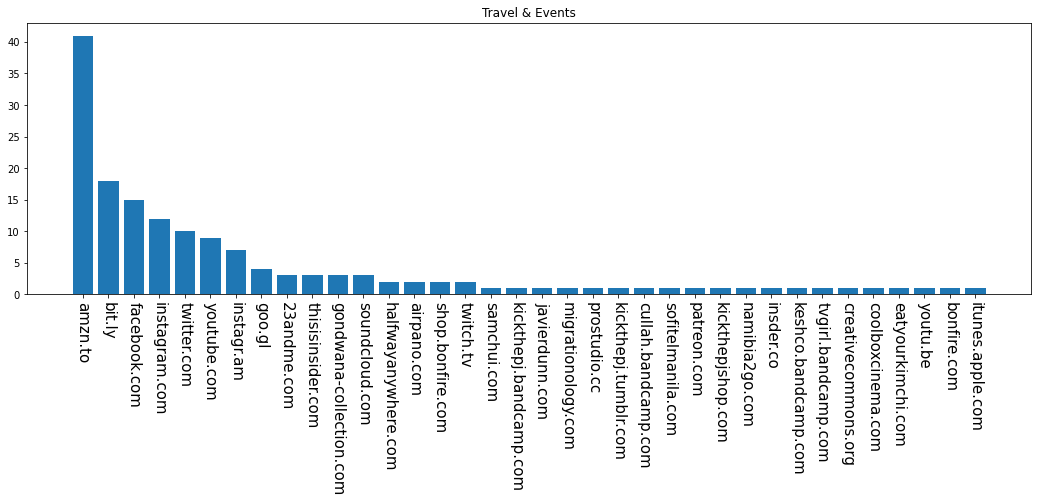

Category 'Gaming' Attr: 'domains' unique words: 108


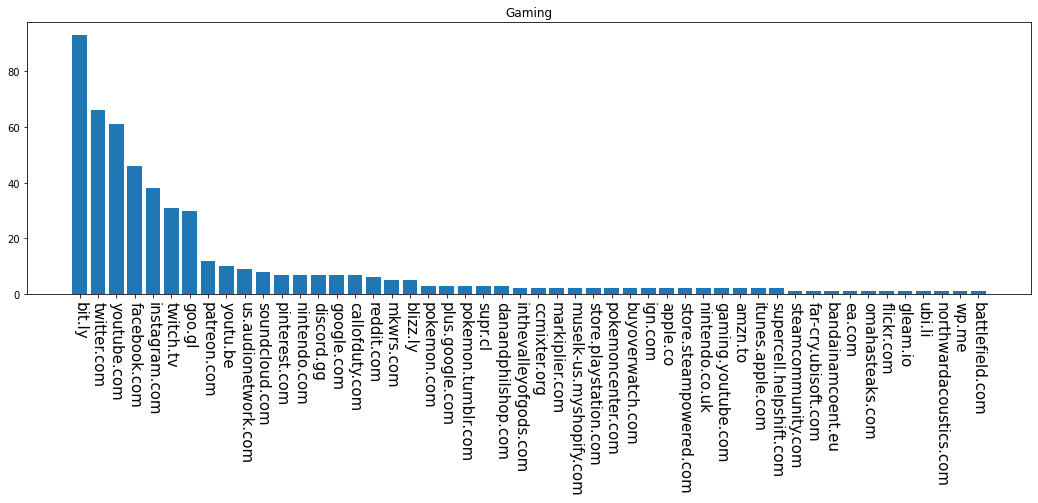

Category 'Education' Attr: 'domains' unique words: 210


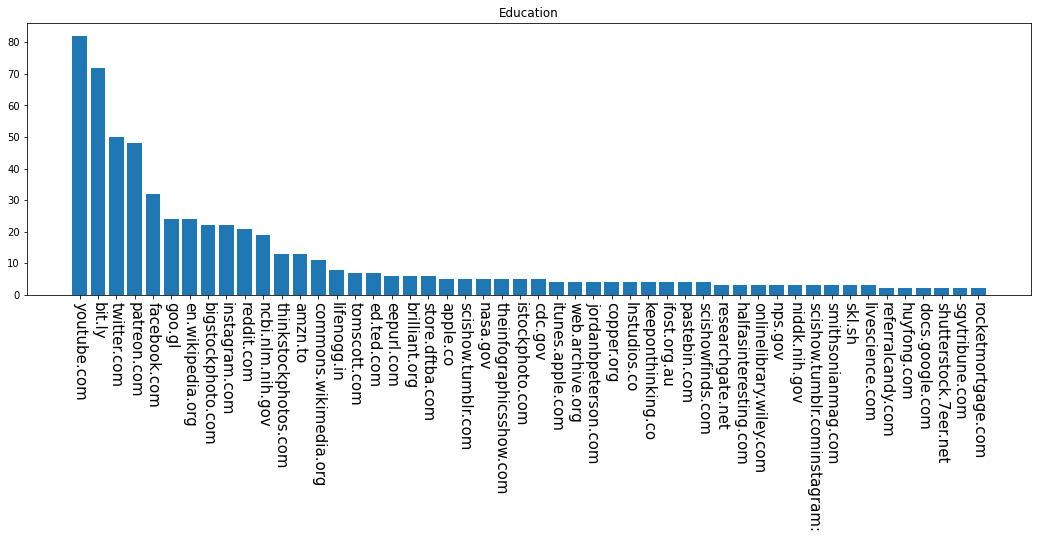

Category 'Pets & Animals' Attr: 'domains' unique words: 56


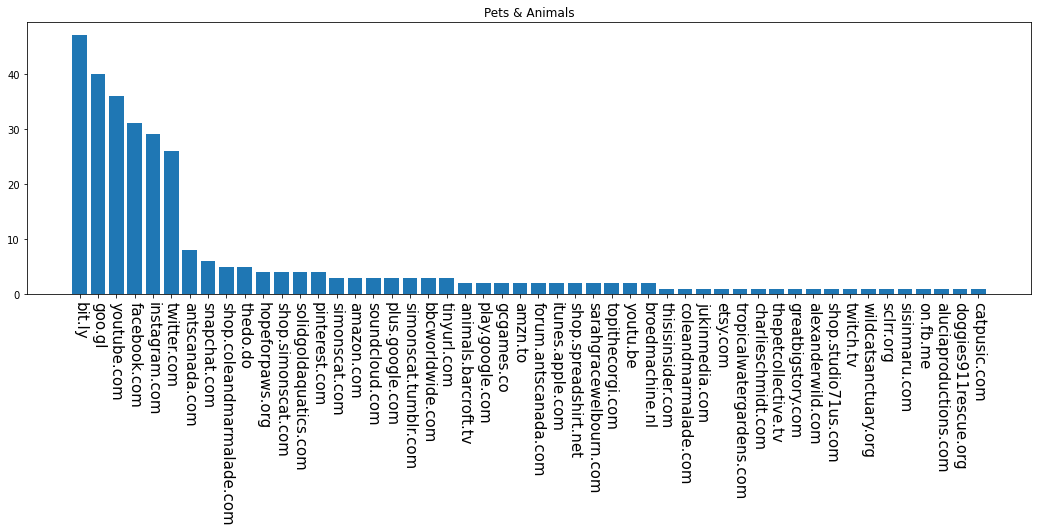

Category 'Science & Technology' Attr: 'domains' unique words: 178


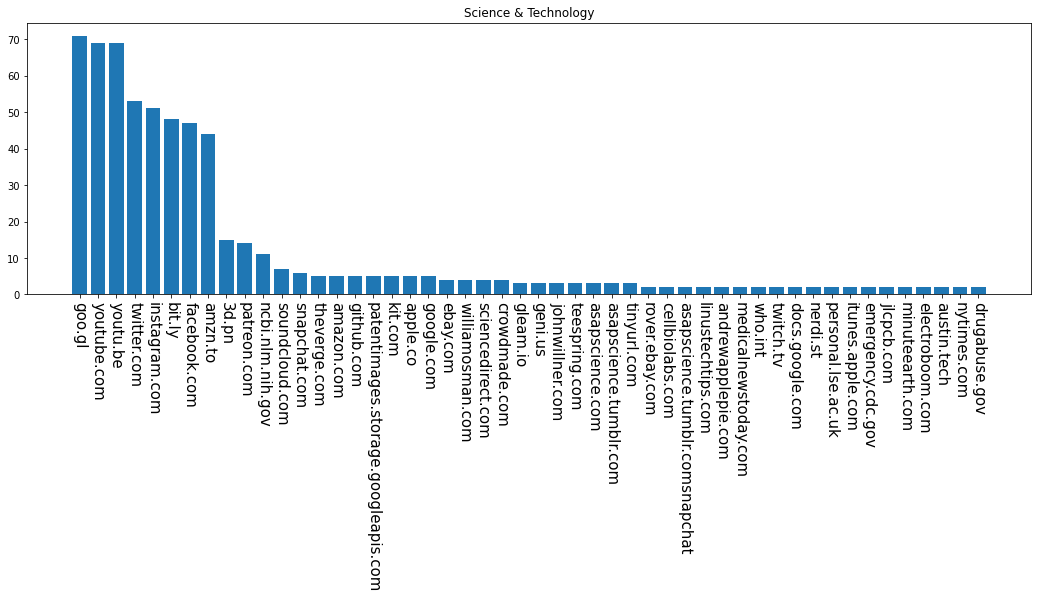

Category 'Film & Animation' Attr: 'domains' unique words: 144


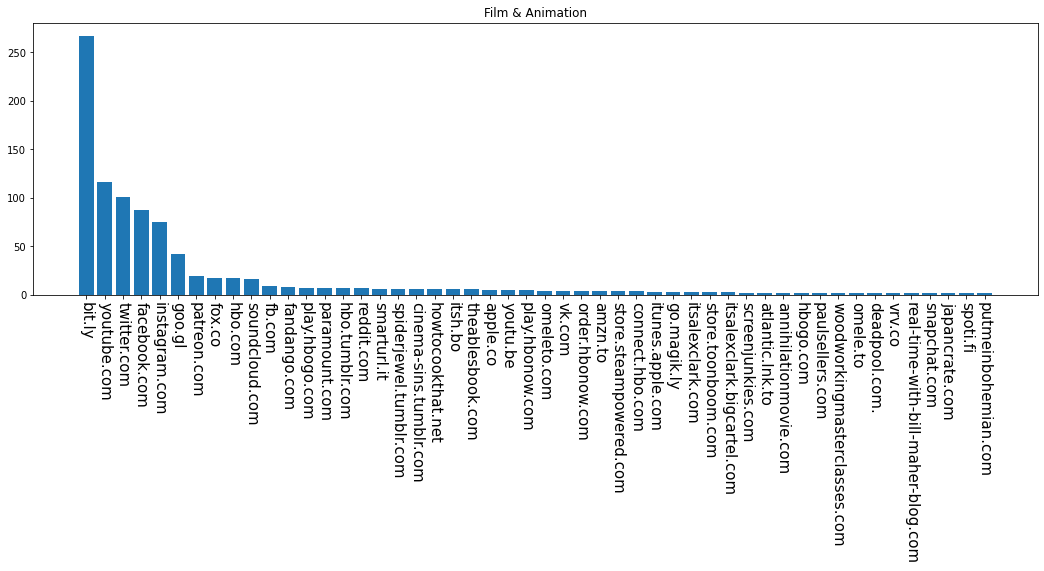

Category 'Autos & Vehicles' Attr: 'domains' unique words: 29


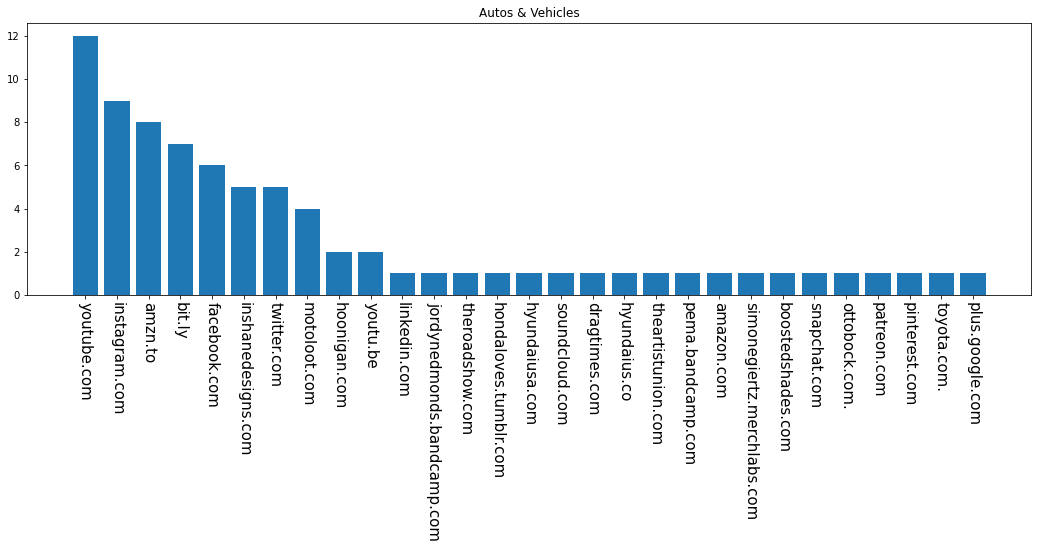

Category 'Nonprofits & Activism' Attr: 'domains' unique words: 1


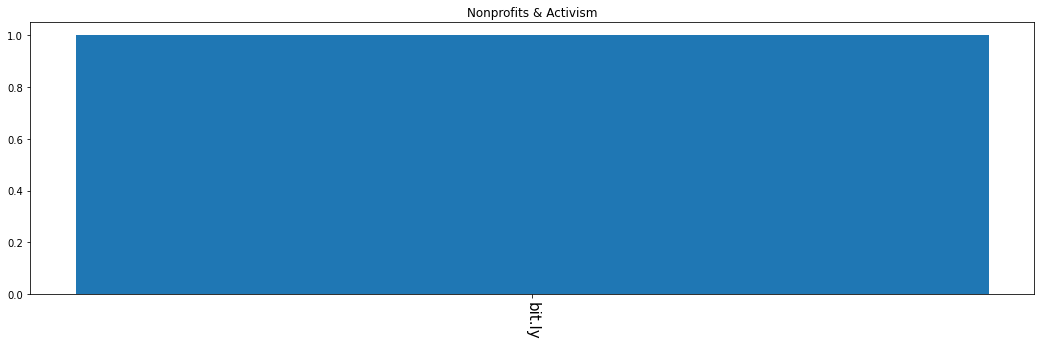

Category 'Shows' Attr: 'domains' unique words: 8


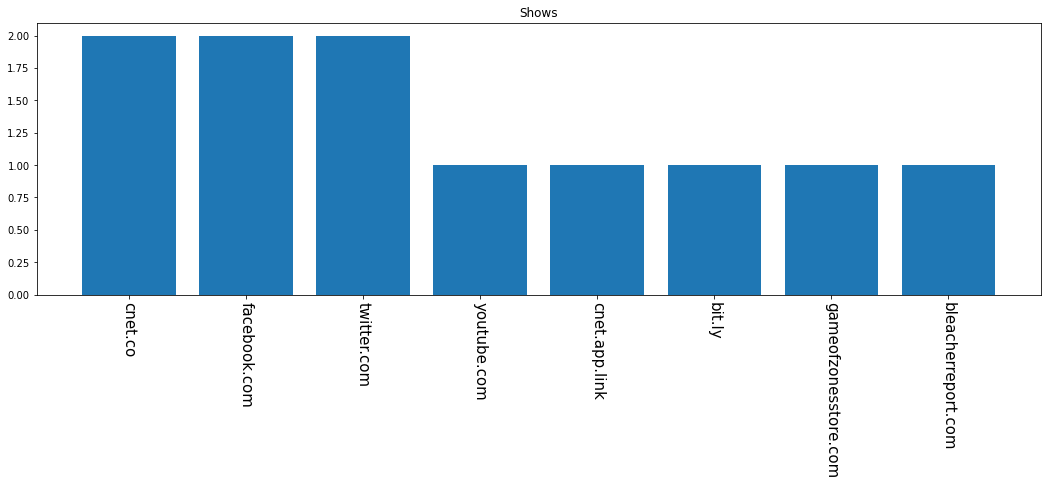

In [13]:
plot_categories_bars(categories, "domains")

## TAGI

Category 'Entertainment' Attr: 'tags' unique words: 8878


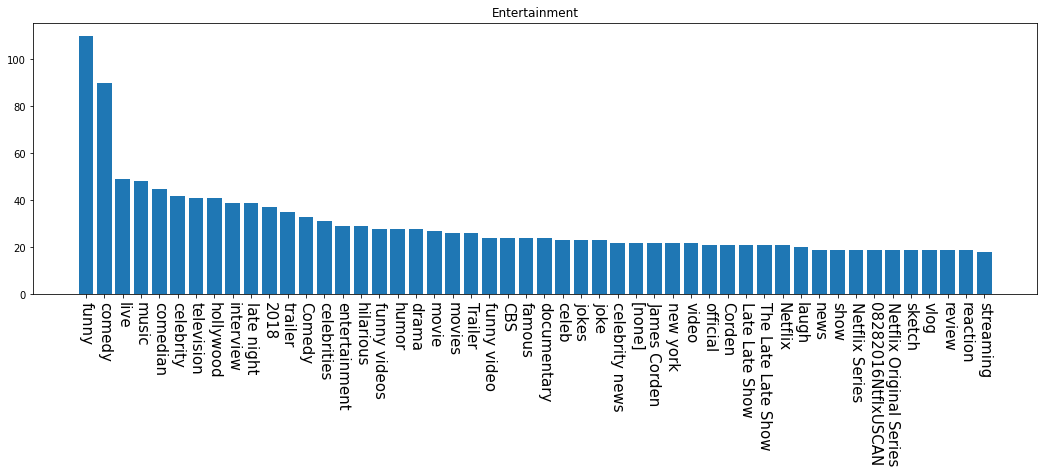

Category 'Music' Attr: 'tags' unique words: 6116


c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45800 missing from current font.
  font.

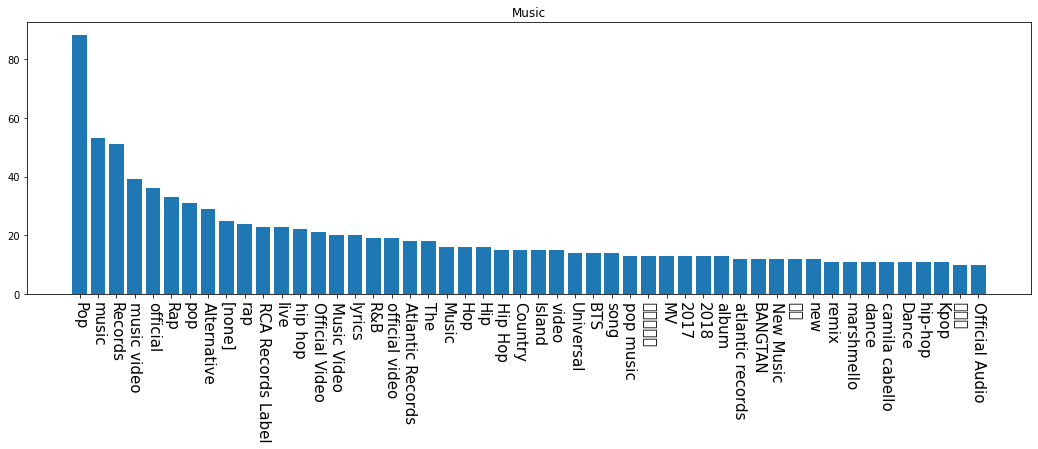

Category 'People & Blogs' Attr: 'tags' unique words: 2774


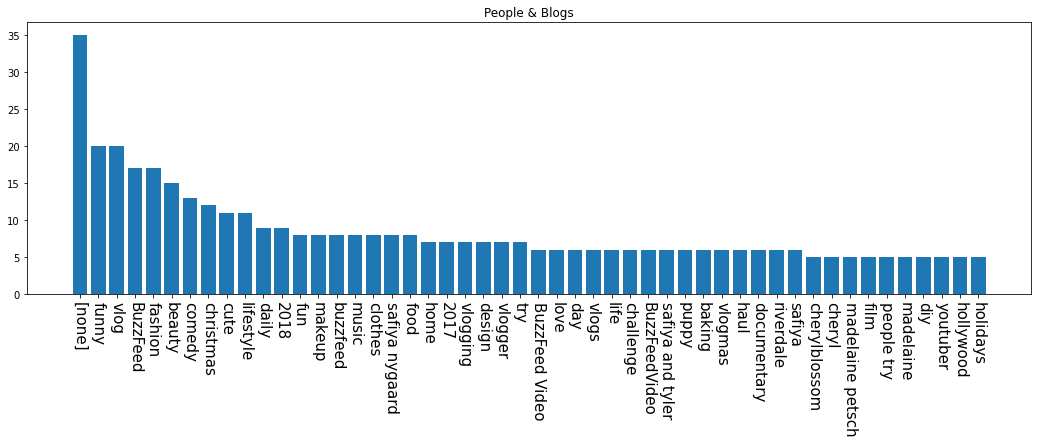

Category 'Howto & Style' Attr: 'tags' unique words: 3137


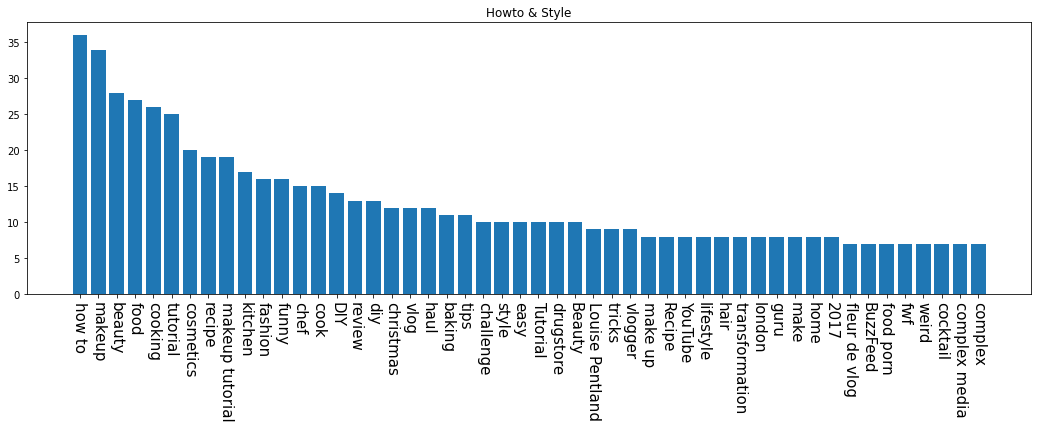

Category 'News & Politics' Attr: 'tags' unique words: 1706


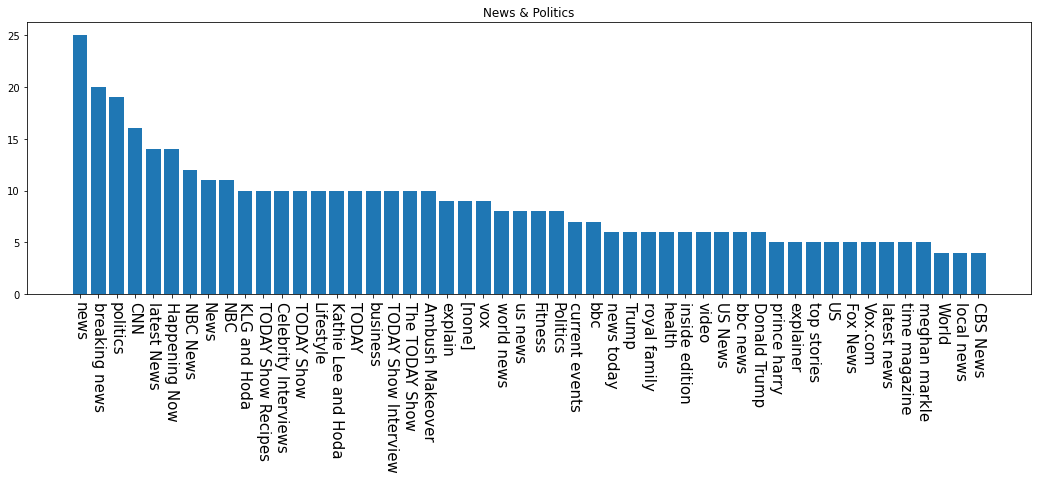

Category 'Comedy' Attr: 'tags' unique words: 2816


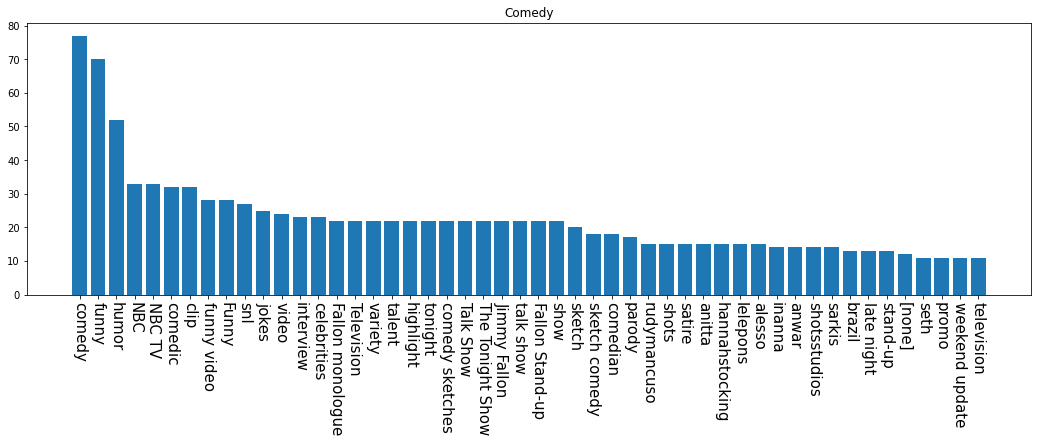

Category 'Sports' Attr: 'tags' unique words: 2749


c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2330 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2369 missing from current font.
  font.set_t

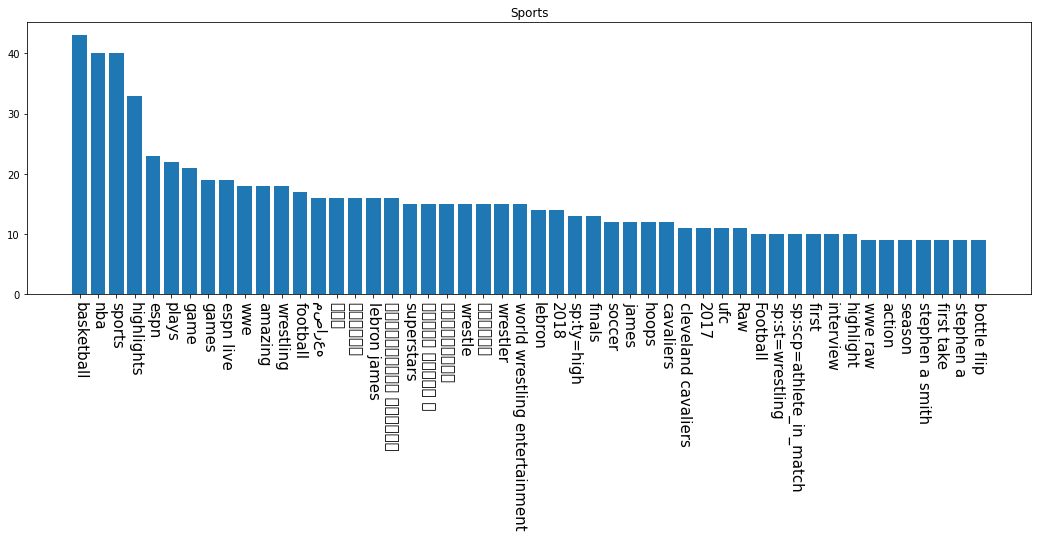

Category 'Travel & Events' Attr: 'tags' unique words: 344


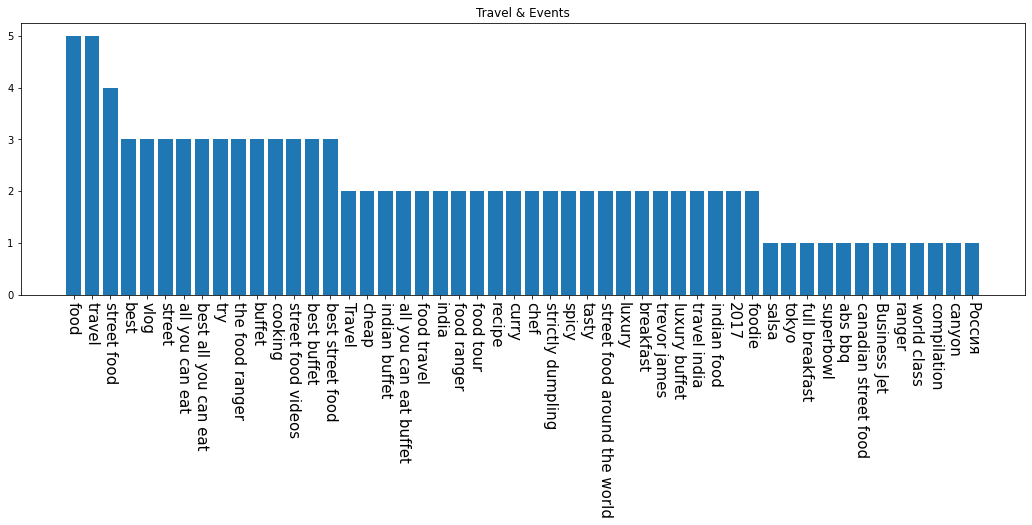

Category 'Gaming' Attr: 'tags' unique words: 1546


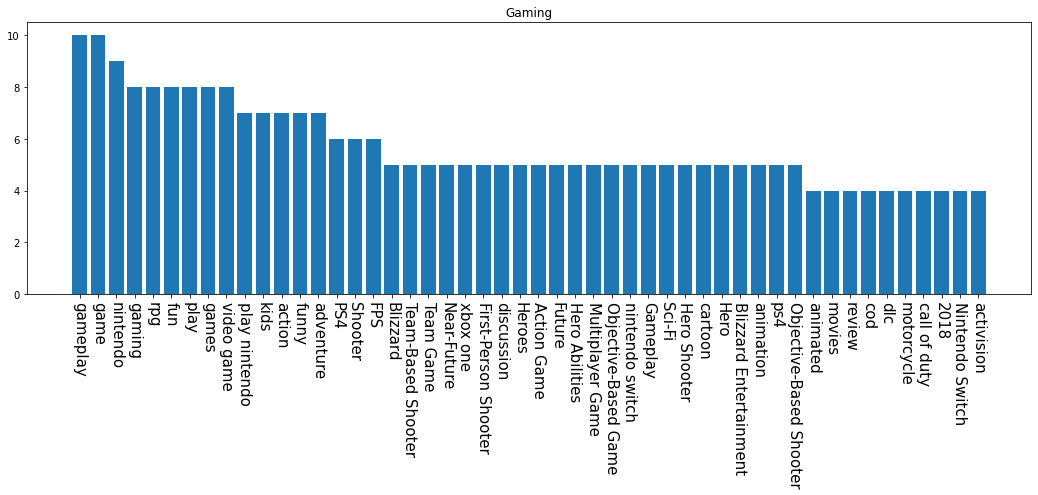

Category 'Education' Attr: 'tags' unique words: 1235


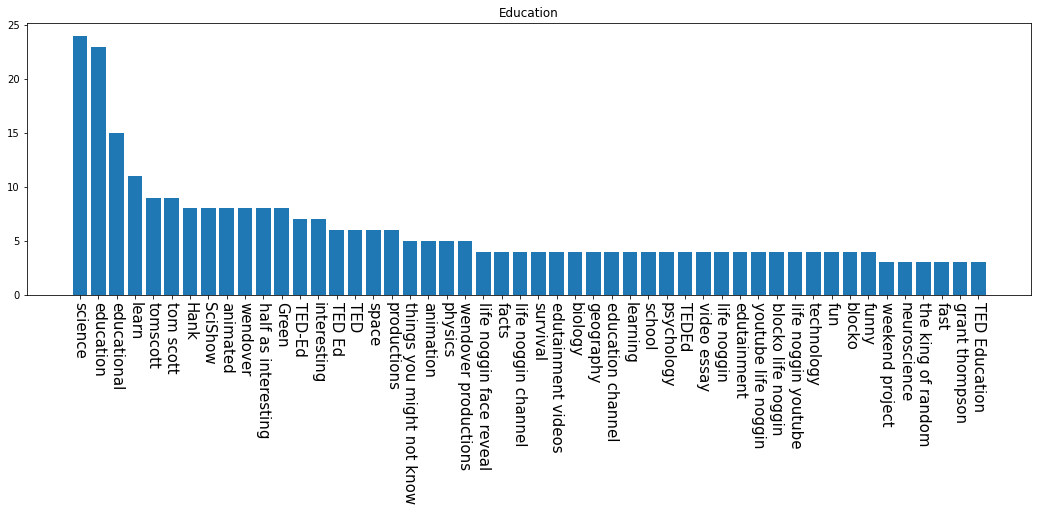

Category 'Pets & Animals' Attr: 'tags' unique words: 793


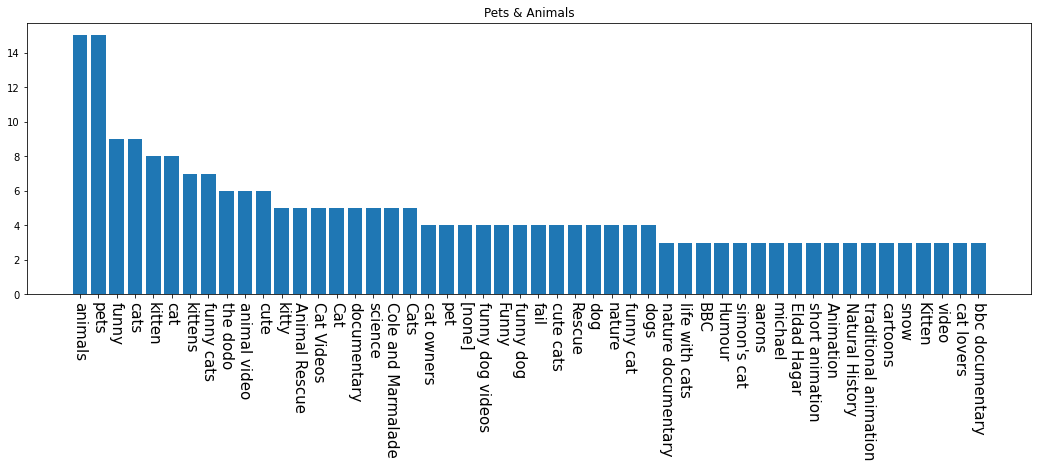

Category 'Science & Technology' Attr: 'tags' unique words: 1340


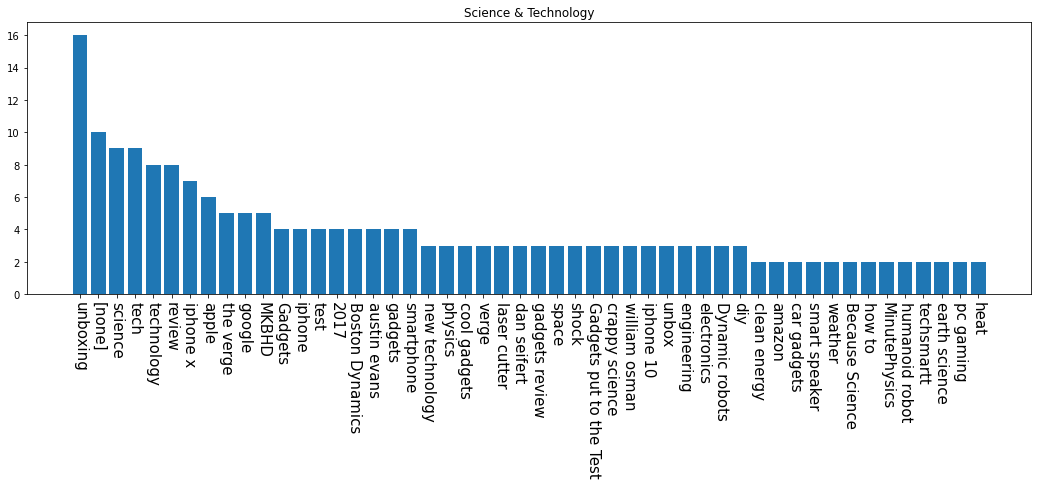

Category 'Film & Animation' Attr: 'tags' unique words: 2178


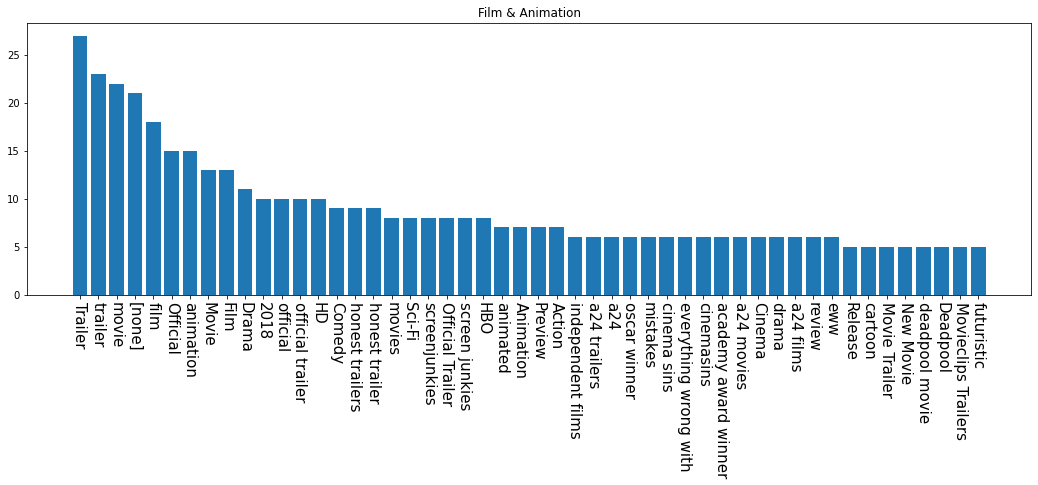

Category 'Autos & Vehicles' Attr: 'tags' unique words: 273


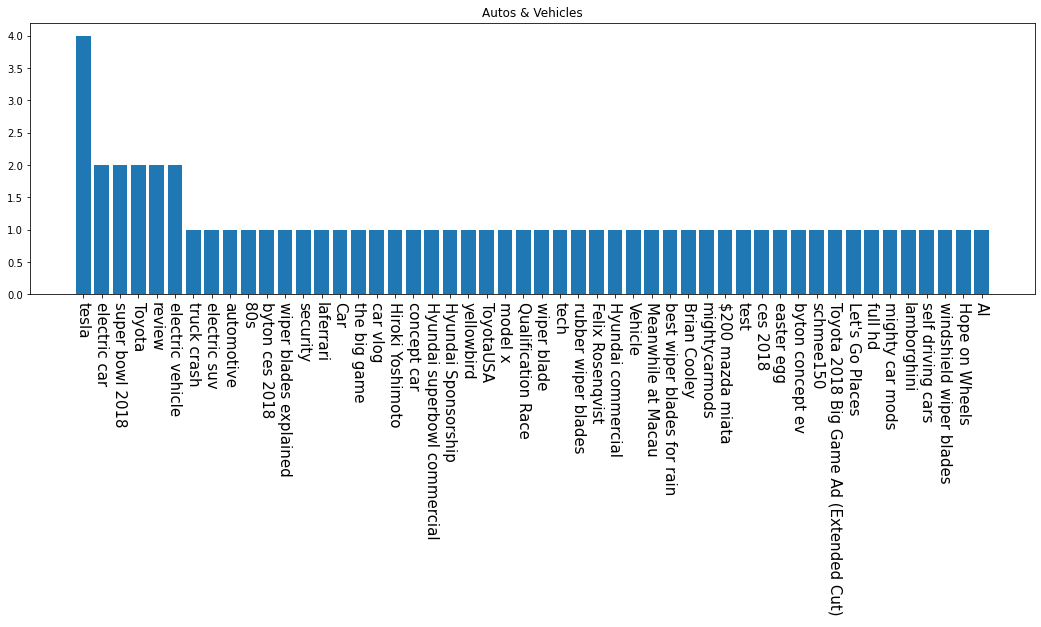

Category 'Nonprofits & Activism' Attr: 'tags' unique words: 88


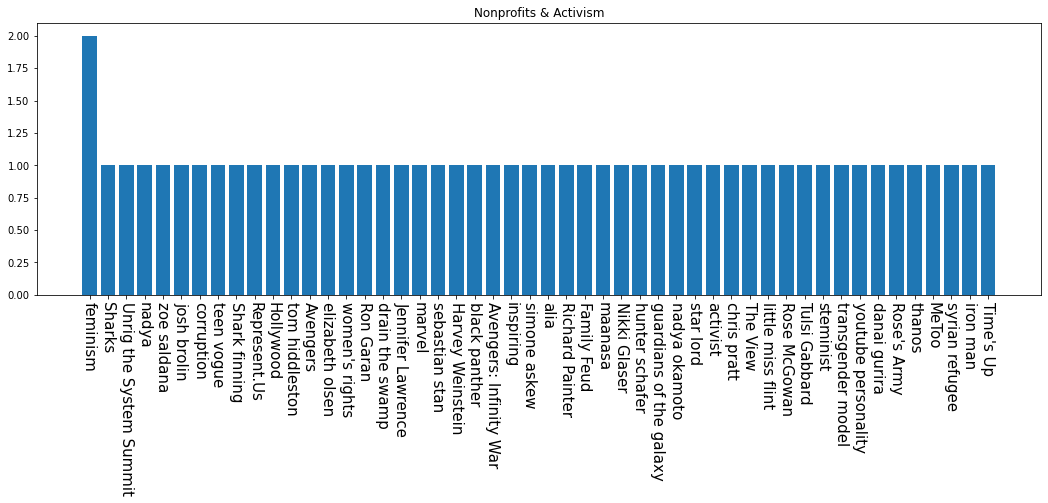

Category 'Shows' Attr: 'tags' unique words: 73


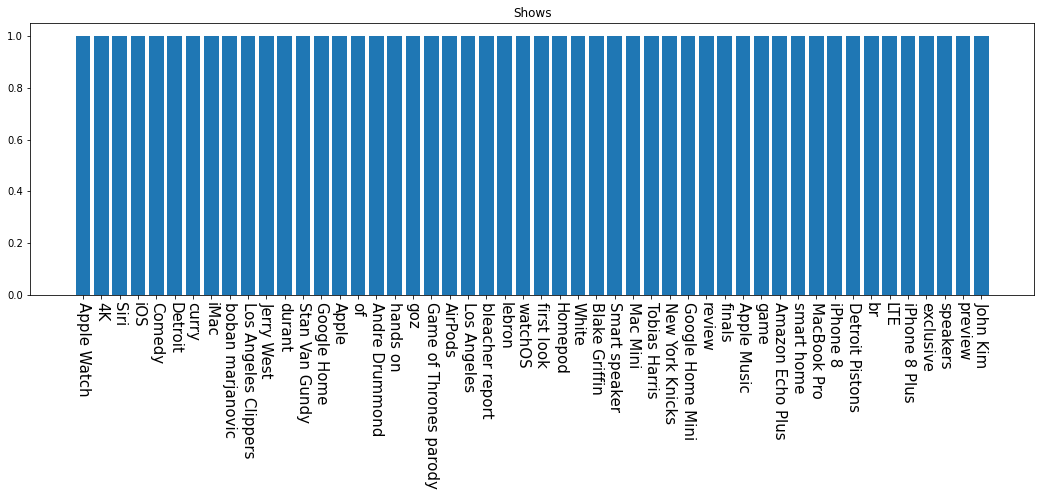

In [14]:
videos["tokenized_tags"] = videos["tags"].apply(lambda x: eval(x)[-1].split("|") if eval(x) else np.nan)
plot_categories_bars(categories, "tags")

## Emocje

Category 'Entertainment' Attr: 'emotion' unique words: 6


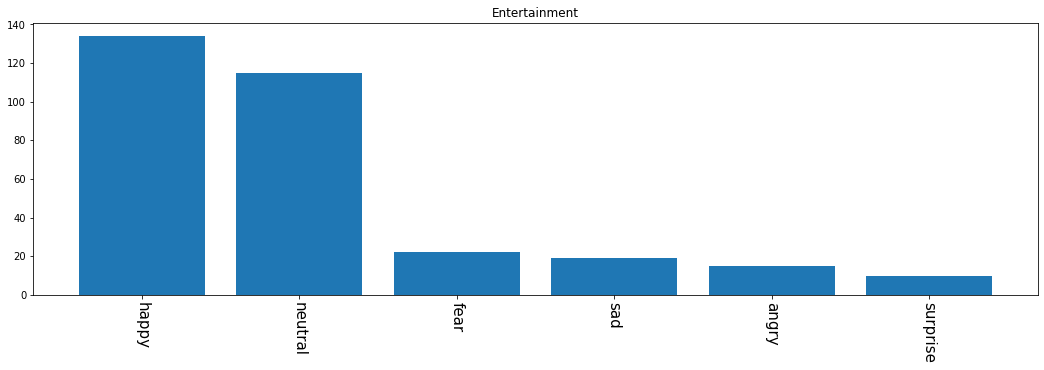

Category 'Music' Attr: 'emotion' unique words: 6


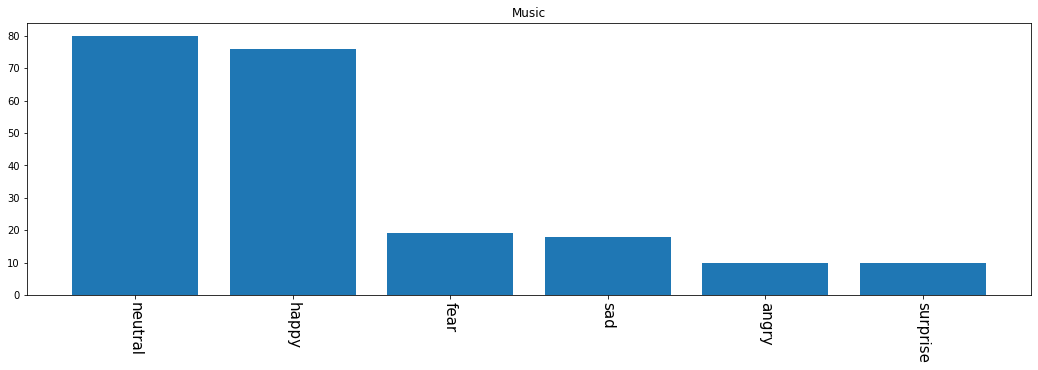

Category 'People & Blogs' Attr: 'emotion' unique words: 7


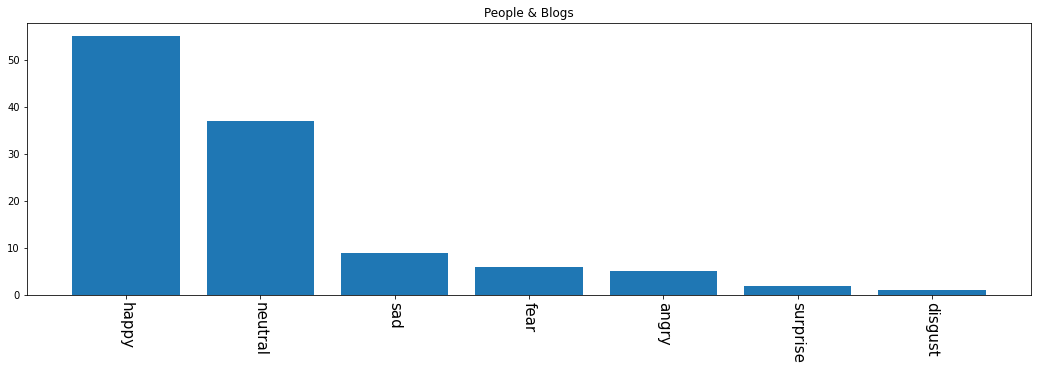

Category 'Howto & Style' Attr: 'emotion' unique words: 6


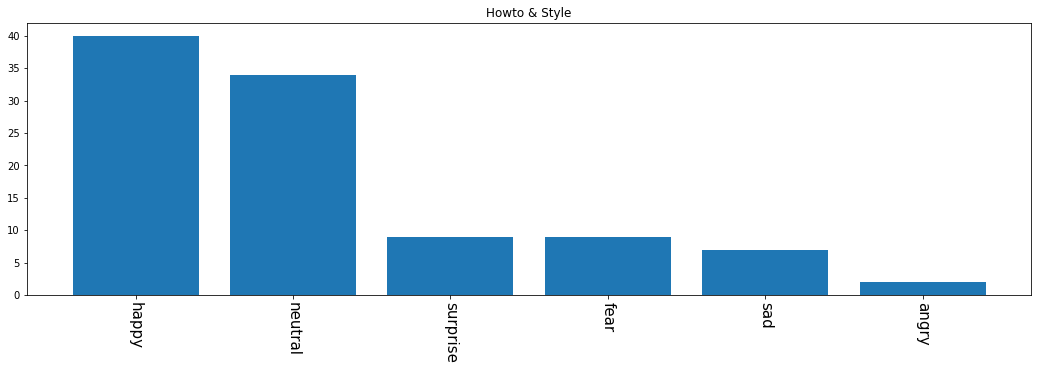

Category 'News & Politics' Attr: 'emotion' unique words: 5


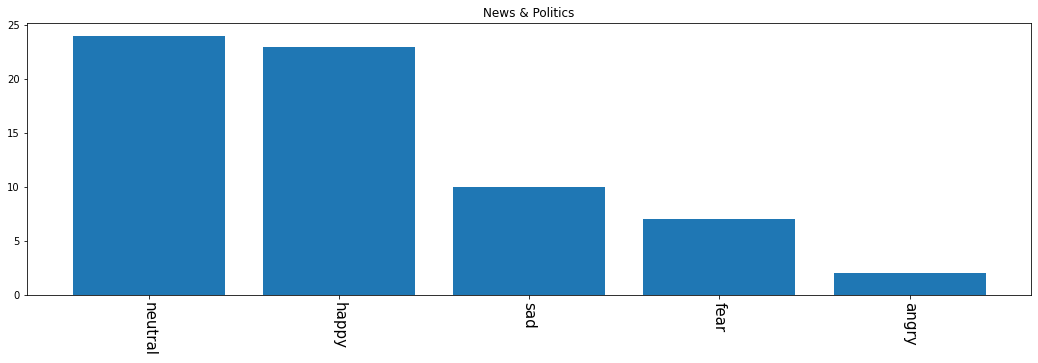

Category 'Comedy' Attr: 'emotion' unique words: 7


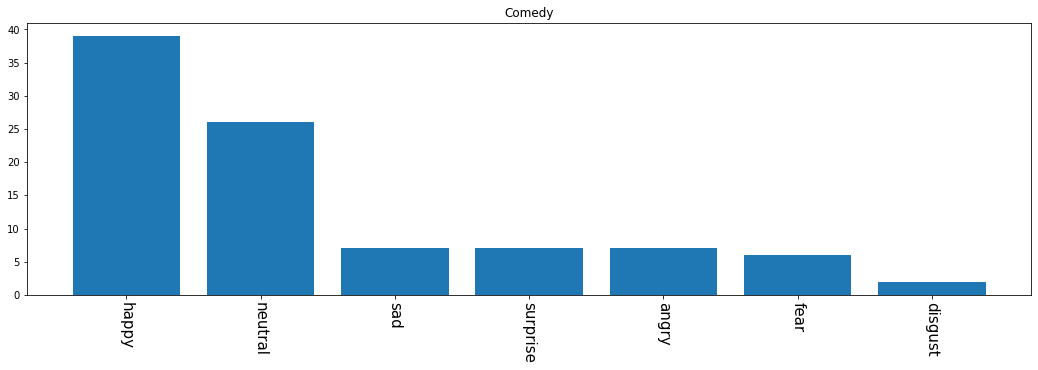

Category 'Sports' Attr: 'emotion' unique words: 6


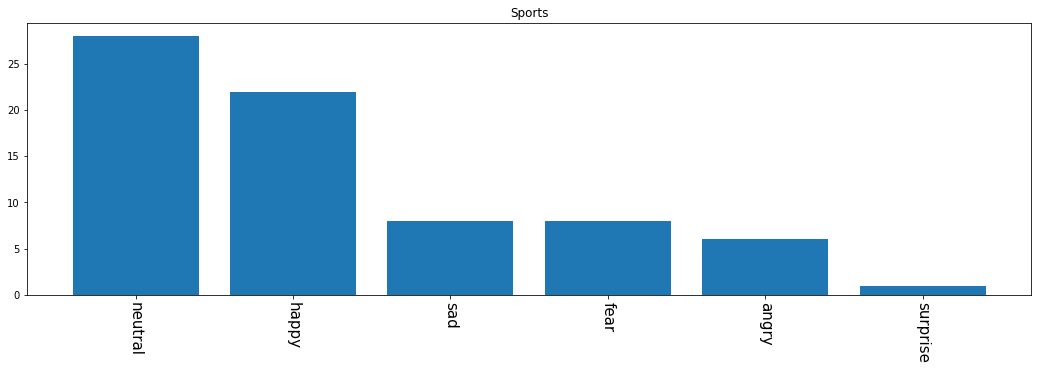

Category 'Travel & Events' Attr: 'emotion' unique words: 3


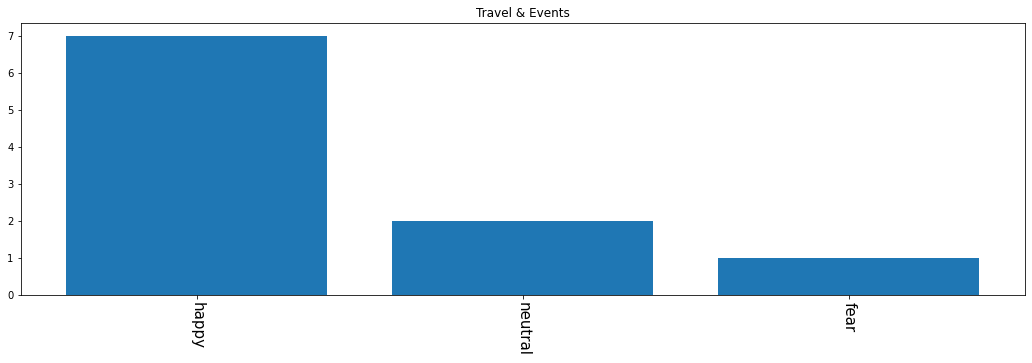

Category 'Gaming' Attr: 'emotion' unique words: 5


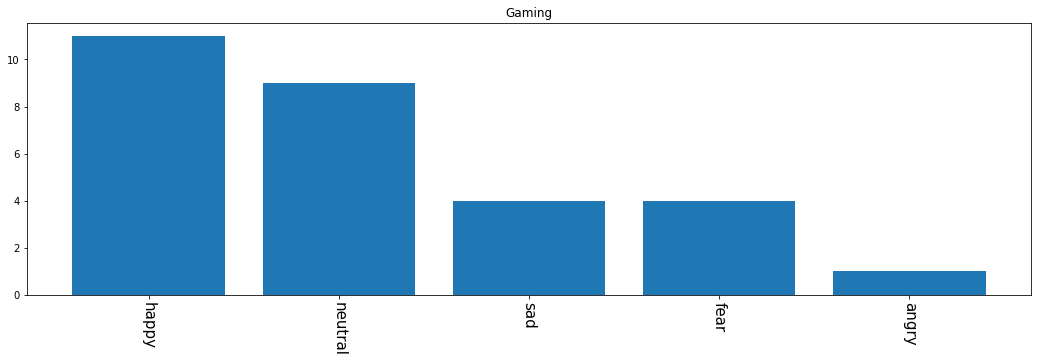

Category 'Education' Attr: 'emotion' unique words: 5


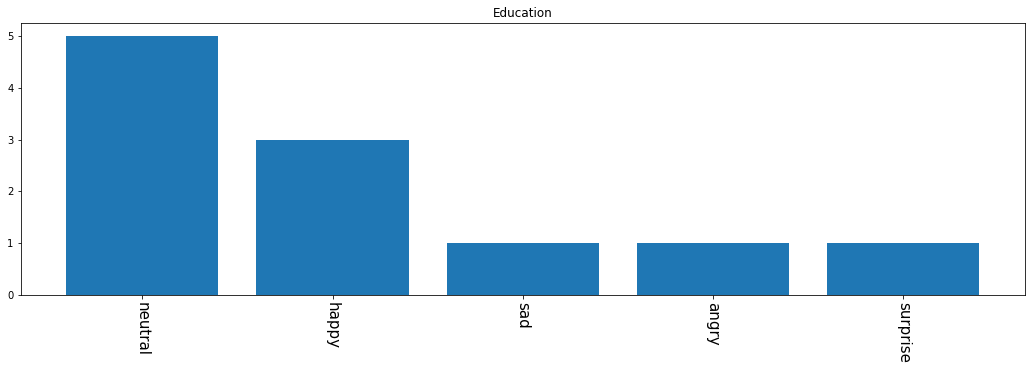

Category 'Pets & Animals' Attr: 'emotion' unique words: 4


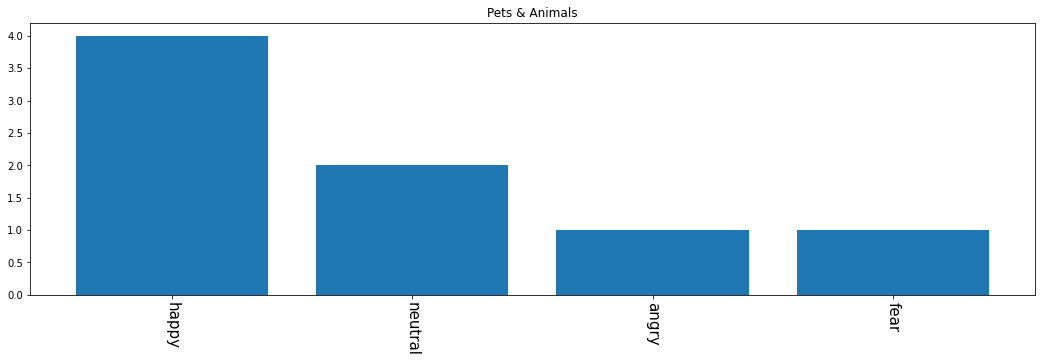

Category 'Science & Technology' Attr: 'emotion' unique words: 4


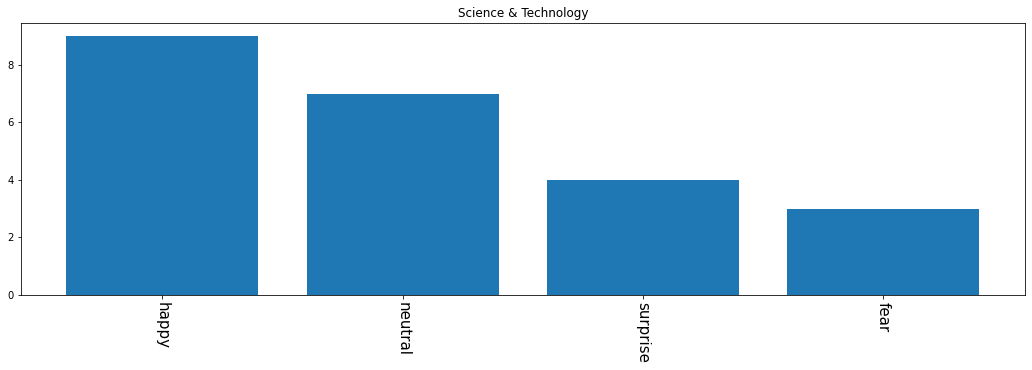

Category 'Film & Animation' Attr: 'emotion' unique words: 6


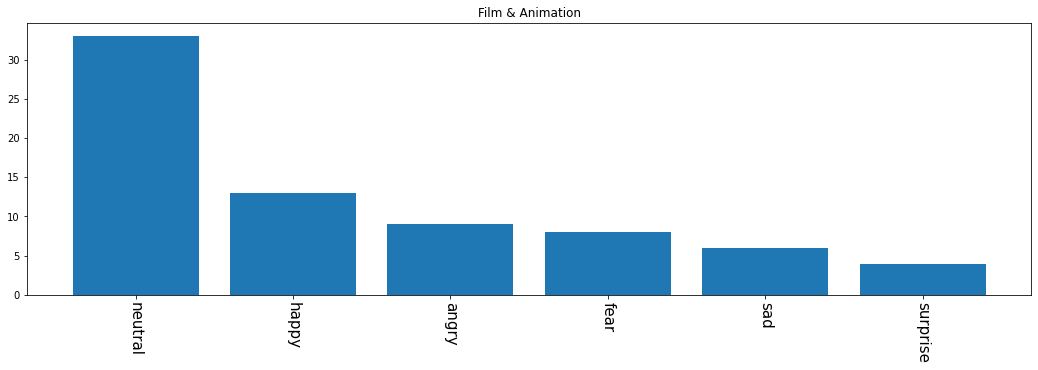

Category 'Autos & Vehicles' Attr: 'emotion' unique words: 0


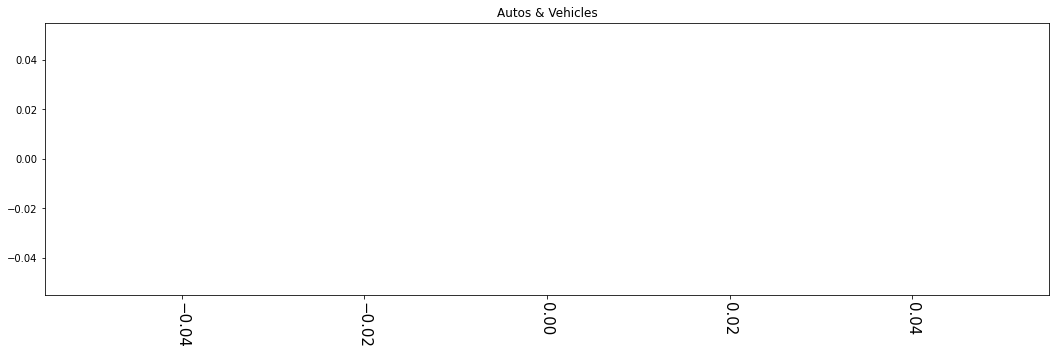

Category 'Nonprofits & Activism' Attr: 'emotion' unique words: 2


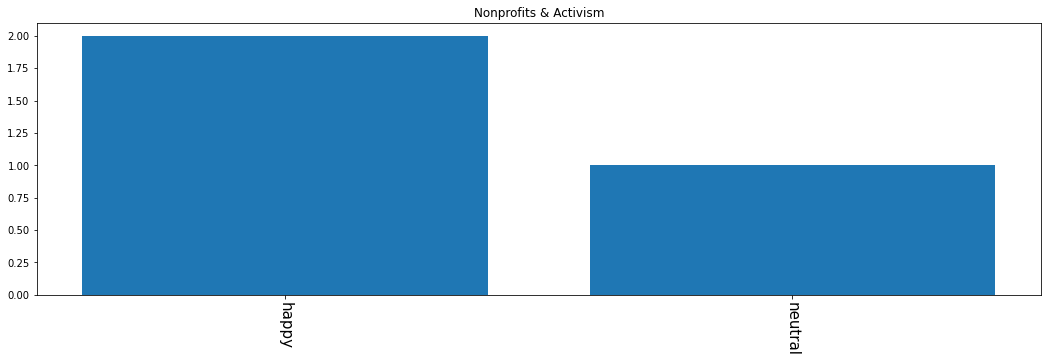

Category 'Shows' Attr: 'emotion' unique words: 1


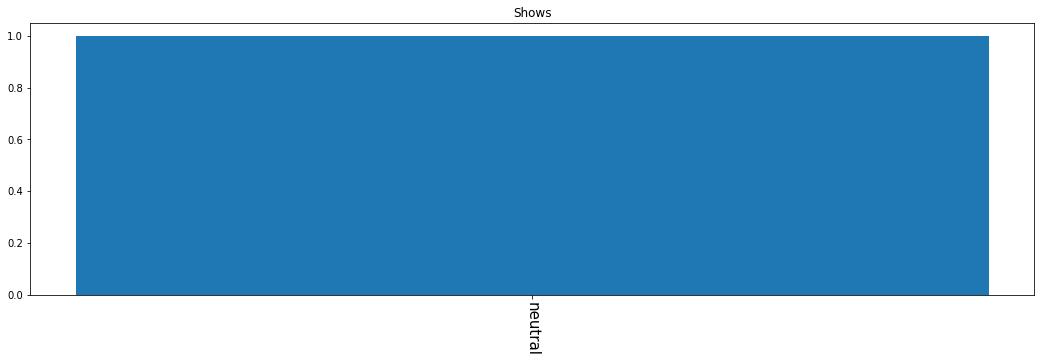

In [15]:
videos["tokenized_emotion"] = videos["emotions"].apply(lambda x: [eval(x)[-1]] if eval(x) else np.nan)
plot_categories_bars(categories, "emotion", create_tokens_dict=False)


Zapisanie słownika z najczęstszymi *n* tokenami występującymi na poszczególnych atrybutach
z podziałem na kategorie.

In [16]:
print(most_frequent_tokens)
save_frequent_tokens_dict("categories", most_frequent_tokens)

{'channel_titles': {'Entertainment': ['live', 'late', 'entertain', 'show', 'pictur', 'netflix', 'saturday', 'night', 'jame', 'good', 'morn', 'theellenshow', 'power', 'corden', 'club', 'star', '105.1', 'kimmel', 'fm', 'breakfast'], 'Music': ['music', 'marshmello', '1', 'ibighit', 'radio', 'bbc', 'record', 'smtown', 'offici', 'charli', 'puth', 'entertain', 'bbcradio1vevo', 'chainsmokersvevo', 'mone', 'ptxoffici', 'andrew', '1thek', 'huang', 'janell'], 'People & Blogs': ['buzzfeedvideo', 'caseyneistat', 'safiya', 'grace', 'nygaard', 'petsch', 'channel90second', 'primit', 'madelain', 'as/i', 'newscom', 'stori', 'moon', 'buzzfeedblu', 'zefrank1', 'guy', 'big', 'slow', 'great', 'mo'], 'Howto & Style': ['sprinkleofglitt', 'feast', 'deforc', 'first', 'fleur', 'tasti', 'laura', 'inthefrow', 'nikkietutori', 'patricia', 'cake', 'bright', 'aina', 'holm', 'apptit', 'tanya', 'amelia', 'burr', 'ell', 'kathleenlight'], 'News & Politics': ['news', 'cnn', 'today', 'cbs', 'abc', 'vox', 'insid', 'bbc', 'f

## Utworzenie atrybutów

In [17]:
def count_tokens(tokens: List[str], atribute: str, category: str) -> float:
    frequent_tokens = most_frequent_tokens[atribute][category]
    if len(tokens) == 0 or len(frequent_tokens) == 0:
        return 0.0
    s = 0
    for t in frequent_tokens:
        if t in tokens:
            s += 1
    return s / len(frequent_tokens)


for attr in tokenized_attrs:
    print(attr)
    for cat in categories:
        videos[f"freq_{attr}_{cat}"] = videos[f"tokenized_{attr}"].apply(lambda x: count_tokens(x, attr, cat))
videos.columns
# videos[f"freq_channel_titles_{categories[0]}"].

channel_titles
descriptions
ocr_text
titles
domains


Index(['new_video_id', 'Unnamed: 0.1', 'video_id', 'trending_date', 'title',
       'channel_title', 'category_id', 'publish_time', 'tags', 'views',
       ...
       'freq_domains_Sports', 'freq_domains_Travel & Events',
       'freq_domains_Gaming', 'freq_domains_Education',
       'freq_domains_Pets & Animals', 'freq_domains_Science & Technology',
       'freq_domains_Film & Animation', 'freq_domains_Autos & Vehicles',
       'freq_domains_Nonprofits & Activism', 'freq_domains_Shows'],
      dtype='object', length=119)

Zapianie danych z utworzonymi atrybutami

In [18]:
gb_data = videos.head(len(gb))
us_data = videos.tail(len(us))

save_csv("ped3_data", [gb_data, us_data], ["GB_videos_5p", "US_videos_5p"])

